In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd

import itertools
import datetime
import copy
import time
import sys  
import re
import os
import glob

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import tf_metrics as metrics

from soundings.preprocessing import dataloader as dl

from soundings.plotting import radiosonde_plotting, results
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'
PLOT_CMAP = 'RdYlBu_r'

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Tue Oct 20 16:07:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   31C    P8    13W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

# Evaluation Functions

In [3]:
def param_search(neural_network_class, product, 
                 Xtrain, Ttrain, Xtest, Ttest,
                 epochs, batch_size, method, lr, verbose=False, **kwargs):
    # https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715
    
    train_history = []
    val_history = []

    best = float('inf')
    best_nnet = None
    best_info = None
    
    f = FloatProgress(min=0, max=len(product))
    display(f)
    for activation, layer in product:
        if 'Convolutional' in str(neural_network_class):
            nnet = neural_network_class(Xtrain.shape[1:], layer, kwargs['kernels_size_and_stride']*len(layer),
                                        Ttrain.shape[1], activation=activation)
        else:
            nnet = neural_network_class(Xtrain.shape[1], layer, Ttrain.shape[1],
                                        activation=activation)
        
        nnet.train(Xtrain, Ttrain, epochs, batch_size, method=method,
                   learning_rate=lr, verbose=verbose, validation=[Xtest, Ttest])

        train_history.append(nnet.history['rmse'][-1])

        temp = nnet.history['val_rmse'][-1]
        val_history.append(temp)

        if temp < best:
            best = temp
            best_nnet = nnet
            best_info = {'epochs': epochs, 'batch_size': batch_size,
                         'method': method, 'lr': lr, 'activation': activation,
                         'layers': layer}
        f.value += 1
        
    print(best_info)
    return best_nnet, train_history, val_history


def plot_param_search(product, train_history, val_history, rotation=30):
    train_color = radiosonde_plotting.DEFAULT_OPTION_DICT[
        radiosonde_plotting.NWP_LINE_COLOUR_KEY]
    val_color = radiosonde_plotting.DEFAULT_OPTION_DICT[
        radiosonde_plotting.PREDICTED_LINE_COLOUR_KEY]
    
    plt.figure(figsize=(12, 5))
    plt.plot(train_history, 'o-', color=train_color)
    plt.plot(val_history, 'o-', color=val_color)

    best_index = np.argmin(val_history)
    best = val_history[best_index]

    plt.hlines(best, 0, len(product) - 1, linestyle='dashed', color='black')
    plt.plot(best_index, best, 'k*', markersize=12)
    plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
               rotation=rotation, horizontalalignment='right')

    plt.legend(('Train', 'Validation', f'Best: {best:.3f}'))
    plt.grid(True); plt.title('Network Variance')
    plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE (C)');

# Data Loader

In [4]:
raob, rap, goes, rtma, sonde_files = dl.load_preprocessed_samples(processed_vol, noaa=True, sgp=False, shuffle=False)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

total of 17605 samples!


FloatProgress(value=0.0, max=17605.0)

time: 521.565, avg: 0.030 seconds
(17605, 256, 4) (17605, 256, 4) (17605, 3, 3, 8) (17605, 3, 3, 3)


In [5]:
nans = np.unique(np.argwhere(np.isnan(raob))[:,0])
nans

array([ 1585,  3086,  3192,  3261,  3730,  4970,  5056,  5366,  5439,
        5610,  5612,  5916,  5965,  6006,  6044,  6087,  6163,  6640,
        6850,  7038,  7057,  7070,  7135,  7152,  7286,  8096,  8141,
        8156,  8159,  8243,  9552, 11546, 11548, 11557, 11604, 11614,
       11628, 11648, 11682, 11696, 11718, 11722, 11728, 11760, 11784,
       11787, 11794, 11797, 14100, 16055, 16086, 16123, 16219, 16235,
       16699, 16725, 16787])

In [6]:
raob = np.delete(raob, nans, 0)
rap  = np.delete(rap, nans, 0)
goes = np.delete(goes, nans, 0)
rtma = np.delete(rtma, nans, 0)
sonde_files = np.delete(np.array(sonde_files), nans, 0)

In [4]:
f = '/mnt/data1/stock/mlsoundings/preprocessed.npz'
# np.savez(f, raob=raob, rap=rap,
#          goes=goes, rtma=rtma, sonde_files=sonde_files)

container = np.load(f)

print(container.files)

raob = container['raob']
rap = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files']

['raob', 'rap', 'goes', 'rtma', 'sonde_files']


In [48]:
raob[:,:,[dl.TEMPERATURE, dl.DEWPOINT]] = raob[:,:,[dl.TEMPERATURE, dl.DEWPOINT]] - rap[:,:,[dl.TEMPERATURE, dl.DEWPOINT]]

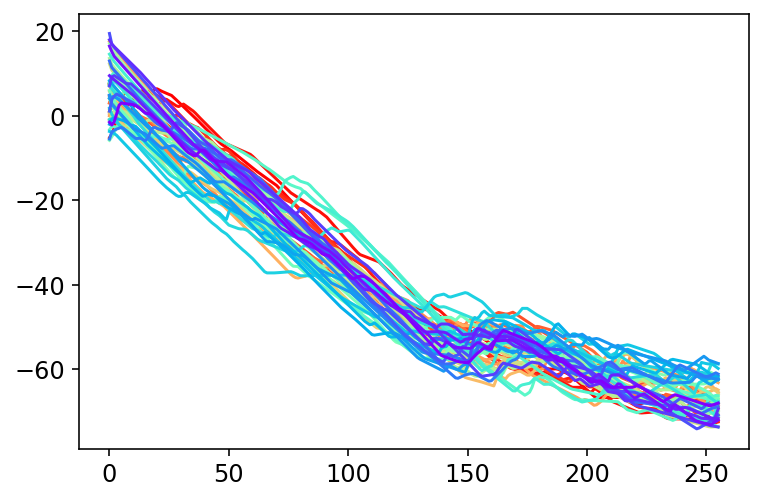

In [112]:
samples = 50
colors = cm.rainbow(np.linspace(1, 0, samples))
for i in range(samples):
    plt.plot(raob[i,:,dl.TEMPERATURE], color=colors[i]);

In [7]:
def plot_level_distn(data, varibale, ms=5):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    levels = np.linspace(0, data.shape[1]-1, ms, dtype=int)
    for i in range(ms):
        measurements = data[:, levels[i], varibale]
        axs[0].hist(measurements, bins=35, alpha=0.35, label=f'{levels[i]}');
    
    data_to_plot = [data[:, levels[i], varibale] for i in range(ms)]
    axs[1].boxplot(data_to_plot)
    axs[1].set_xticklabels(levels);
    
    axs[0].legend(); 
    axs[0].set_xlabel('Degree [C]'); axs[1].set_ylabel('Count')
    axs[1].set_xlabel('Level Index'); axs[1].set_ylabel('Degree [C]')
    
    fig.tight_layout()

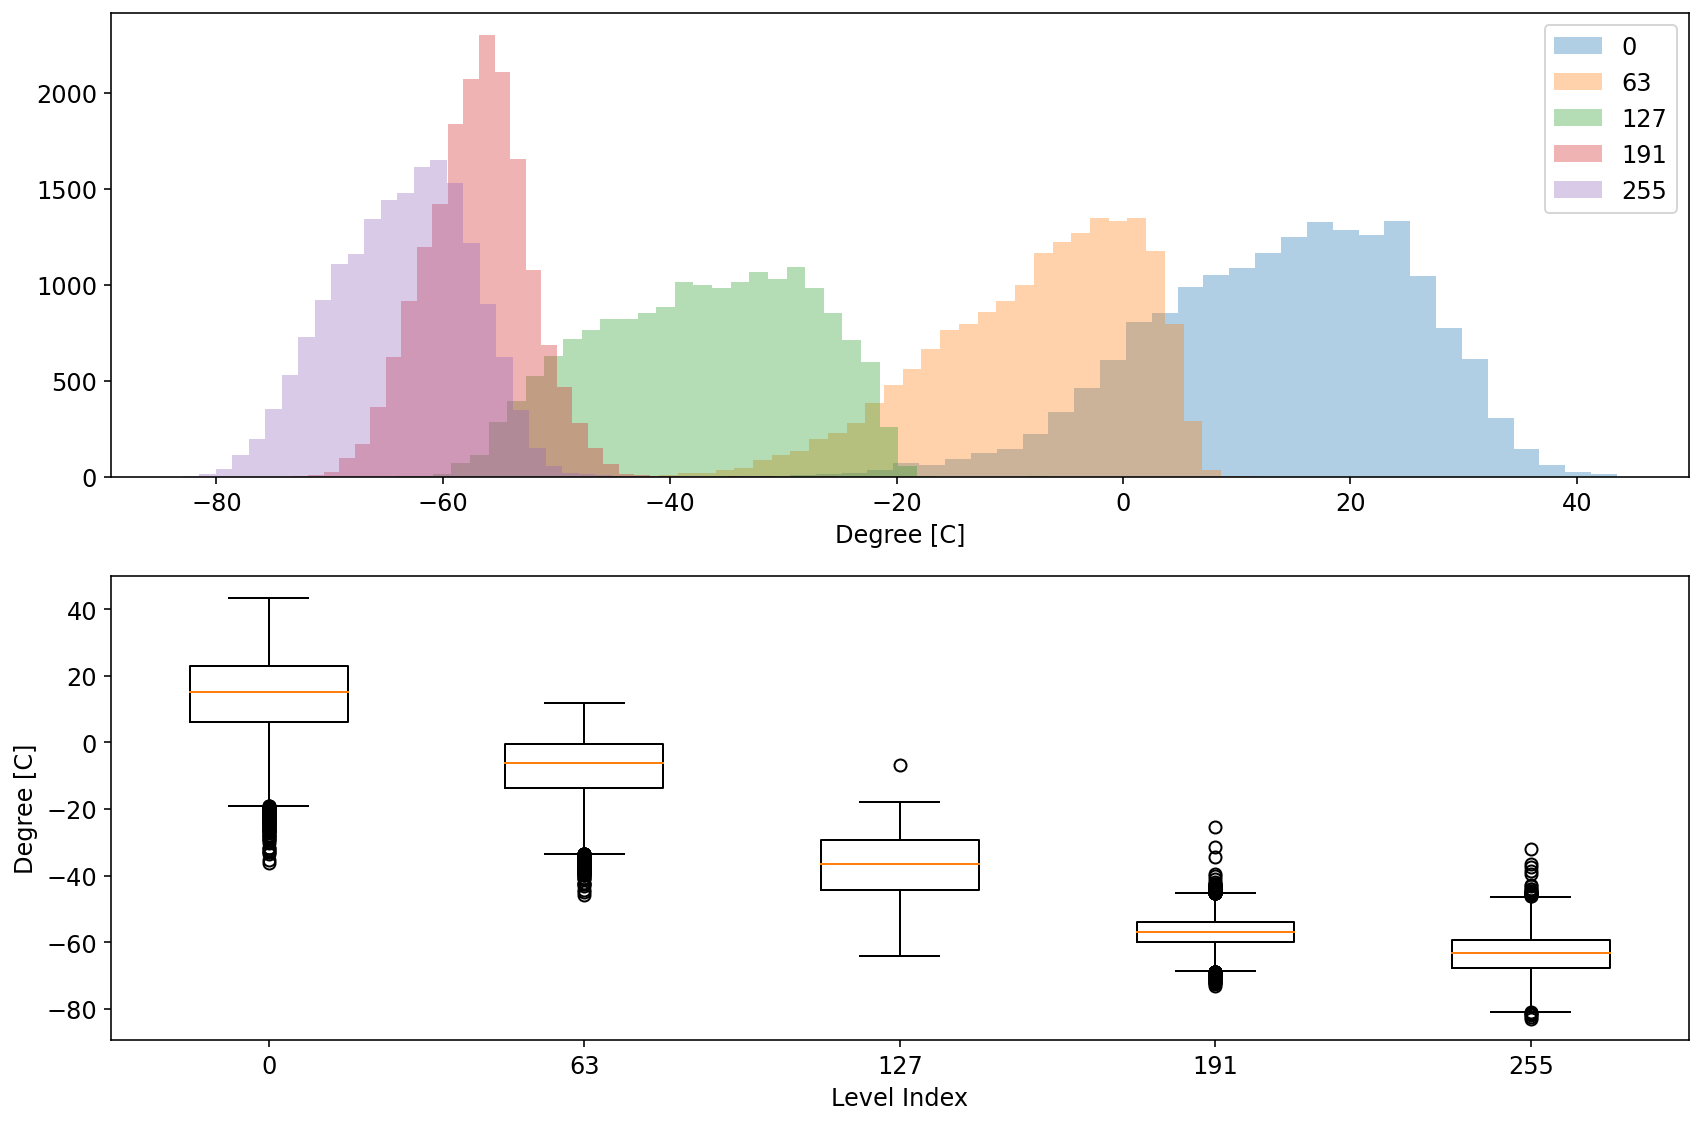

In [57]:
plot_level_distn(raob, dl.TEMPERATURE, ms=5)

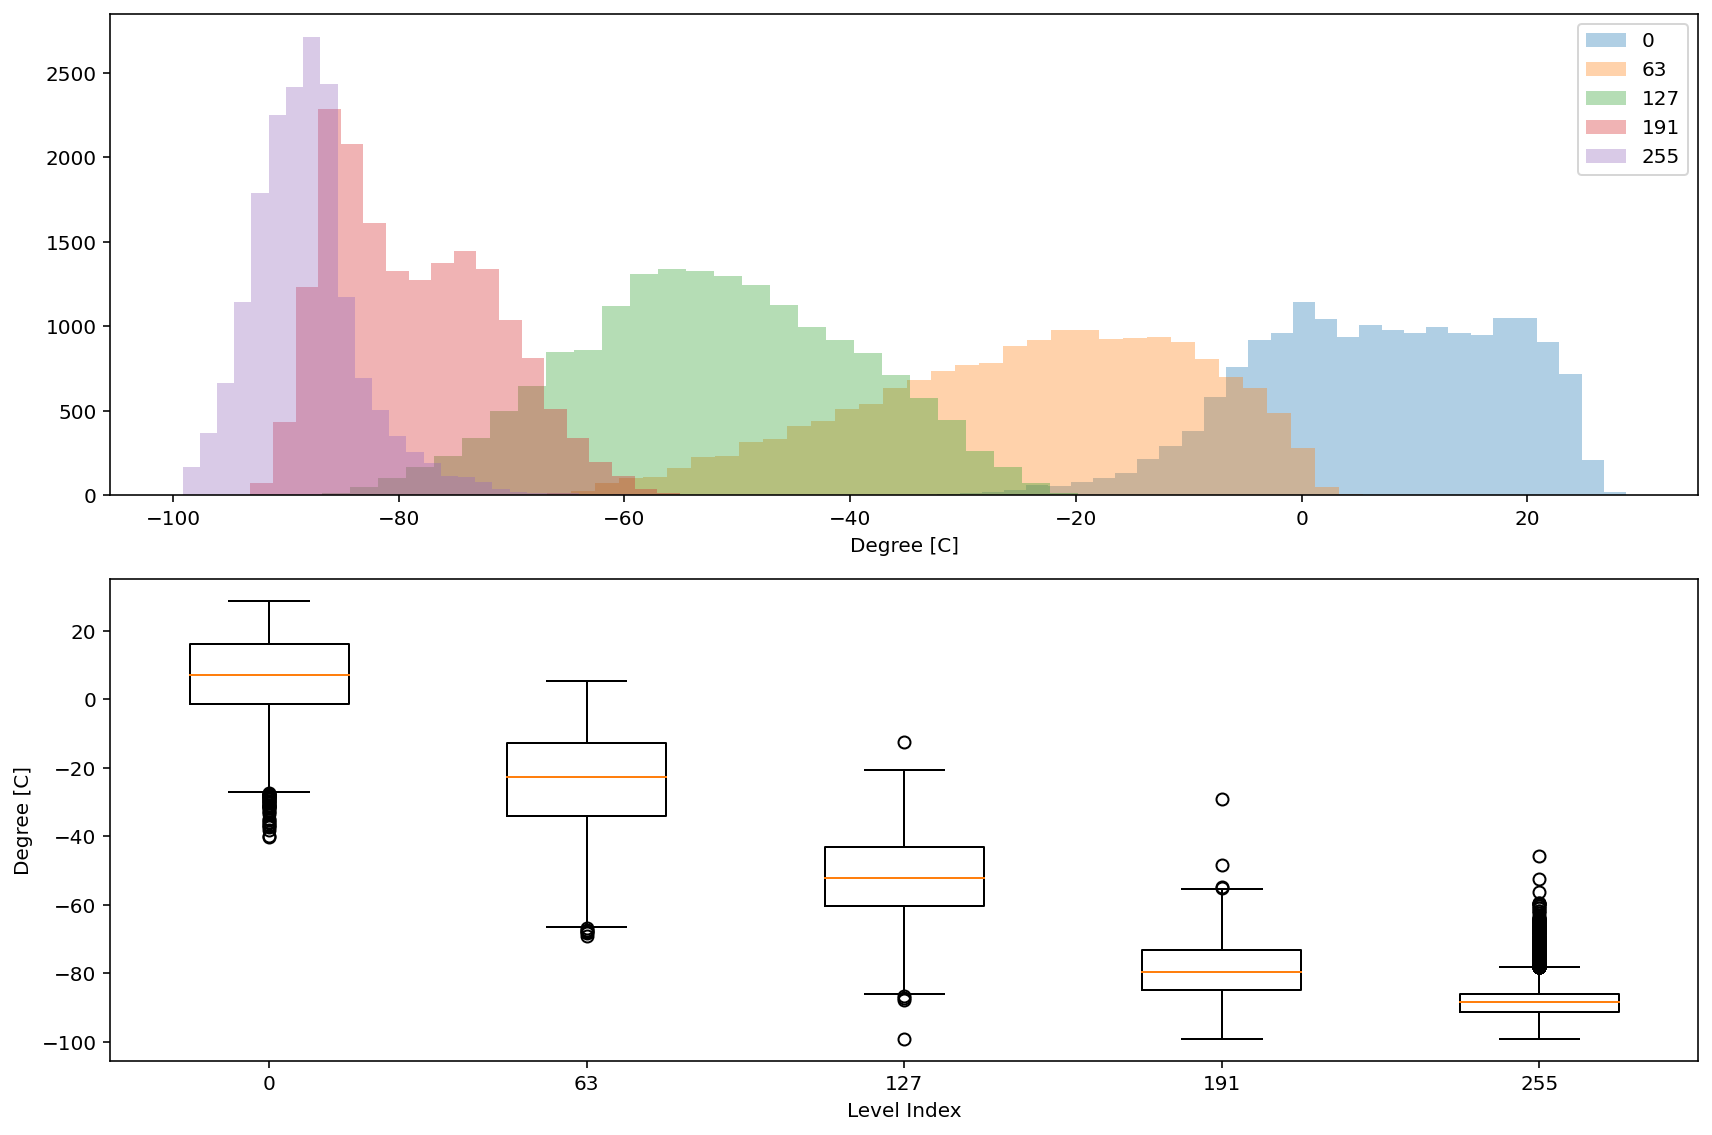

In [9]:
plot_level_distn(raob, dl.DEWPOINT, ms=5)

Unique Sites: 72


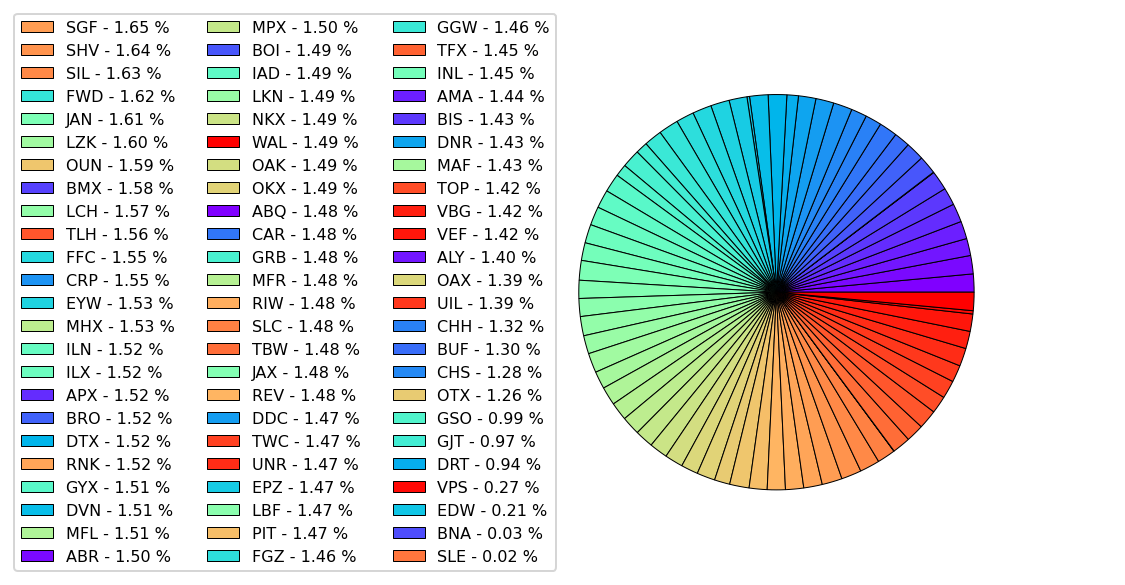

In [23]:
sites = np.array(sorted([fn.split('/')[-1].split('_')[0] for fn in glob.glob(os.path.join(processed_vol, '*')) 
                         if not os.path.basename(fn).startswith('sgp')]))

site_names, counts = np.unique(sites, return_counts=True)
print('Unique Sites:', len(site_names))

fig, ax = plt.subplots()

colors = cm.rainbow(np.linspace(0, 1, len(site_names)))

patches, texts = ax.pie(counts, colors=colors,
                         wedgeprops={'edgecolor':'k', 'linewidth': 0.5, 'antialiased': True})
ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

percent = 100.*counts/counts.sum()
labels = ['{0} - {1:1.2f} %'.format(i.upper(),j) for i,j in zip(site_names, percent)]
# sort legend
patches, labels, _ =  zip(*sorted(zip(patches, labels, counts),
                                      key=lambda x: x[2],
                                      reverse=True))

ax.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.65, 0.5), fontsize=8, ncol=3);

In [24]:
ml.rmse(rap[:,:,dl.DEWPOINT], raob[:,:,dl.DEWPOINT]), ml.rmse(rap[:,:,dl.TEMPERATURE], raob[:,:,dl.TEMPERATURE])

(5.6679463782139345, 1.1539530597632257)

In [8]:
for i in range(len(raob)):
    print(''.join(['-']*25))
#     print(f'Pressure:  {raob[i,0,dl.PRESSURE]:.3f}, {rap[i,0,dl.PRESSURE]:.3f}')
#     print(f'Temperature: {raob[i,0,dl.TEMPERATURE]:.3f}, {rap[i,0,dl.TEMPERATURE]:.3f}')
#     print(f'Dewpoint: {raob[i,0,dl.DEWPOINT]:.3f}, {rap[i,0,dl.DEWPOINT]:.3f}')
    print(f'Altitude: {raob[i,0,dl.ALTITUDE]:.3f}, {rap[i,0,dl.ALTITUDE]:.3f}')

-------------------------
Altitude: 1619.000, 1638.730
-------------------------
Altitude: 1619.000, 1638.620
-------------------------
Altitude: 397.000, 408.235
-------------------------
Altitude: 397.000, 407.867
-------------------------
Altitude: 94.000, 97.735
-------------------------
Altitude: 94.000, 97.242
-------------------------
Altitude: 1095.000, 1099.120
-------------------------
Altitude: 448.000, 413.735
-------------------------
Altitude: 448.000, 413.117
-------------------------
Altitude: 503.000, 548.860
-------------------------
Altitude: 503.000, 548.445
-------------------------
Altitude: 178.000, 173.235
-------------------------
Altitude: 178.000, 172.992
-------------------------
Altitude: 180.000, 171.110
-------------------------
Altitude: 180.000, 170.867
-------------------------
Altitude: 871.000, 960.110
-------------------------
Altitude: 871.000, 959.742
-------------------------
Altitude: 7.000, 17.360
-------------------------
Altitude: 7.000, 17.1

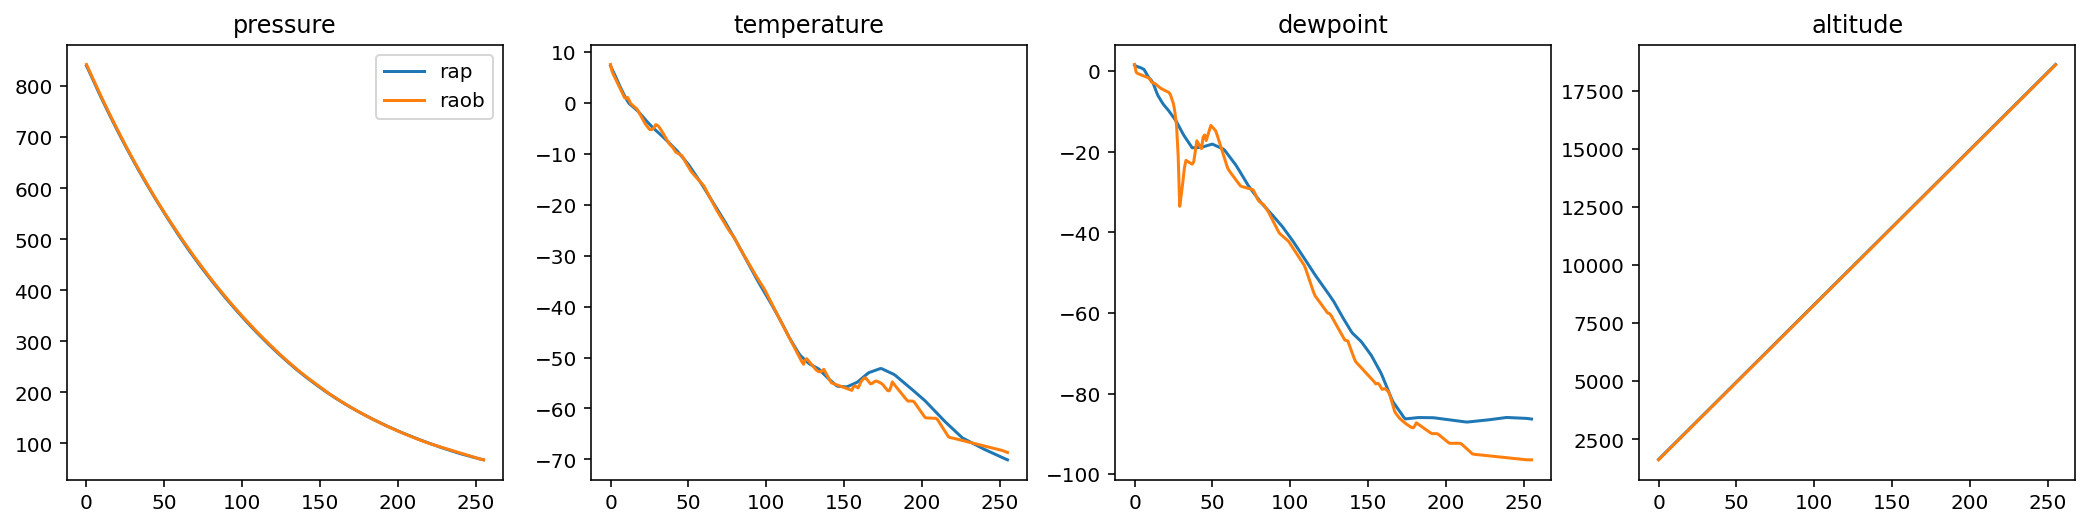

In [9]:
index = 8
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

axs[0].plot(rap[index,:,dl.PRESSURE], label='rap')
axs[0].plot(raob[index,:,dl.PRESSURE], label='raob')
axs[0].set_title('pressure')

axs[1].plot(rap[index,:,dl.TEMPERATURE], label='rap')
axs[1].plot(raob[index,:,dl.TEMPERATURE], label='raob')
axs[1].set_title('temperature')

axs[2].plot(rap[index,:,dl.DEWPOINT], label='rap')
axs[2].plot(raob[index,:,dl.DEWPOINT], label='raob')
axs[2].set_title('dewpoint')

axs[3].plot(rap[index,:,dl.ALTITUDE], label='rap')
axs[3].plot(raob[index,:,dl.ALTITUDE], label='raob')
axs[3].set_title('altitude')

axs[0].legend()

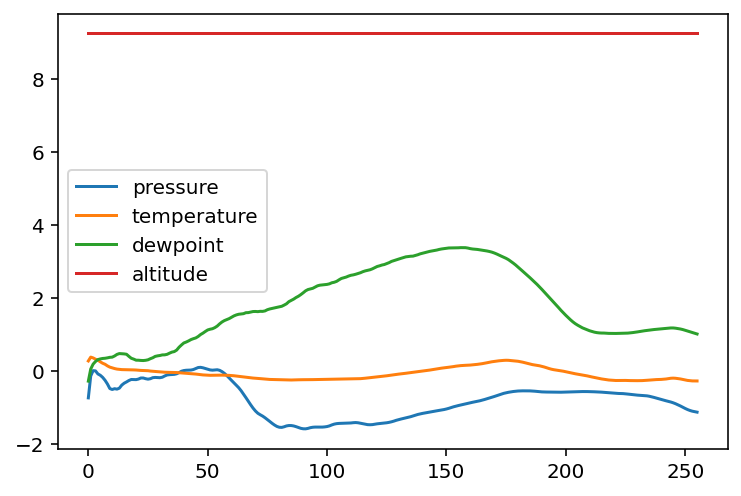

In [10]:
index = 8
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

axs.plot(np.mean(rap[:,:,dl.PRESSURE] - raob[:,:,dl.PRESSURE], axis=0), label='pressure')
axs.plot(np.mean(rap[:,:,dl.TEMPERATURE] - raob[:,:,dl.TEMPERATURE], axis=0), label='temperature')
axs.plot(np.mean(rap[:,:,dl.DEWPOINT] - raob[:,:,dl.DEWPOINT], axis=0), label='dewpoint')
axs.plot(np.mean(rap[:,:,dl.ALTITUDE] - raob[:,:,dl.ALTITUDE], axis=0), label='altitude')
axs.legend()


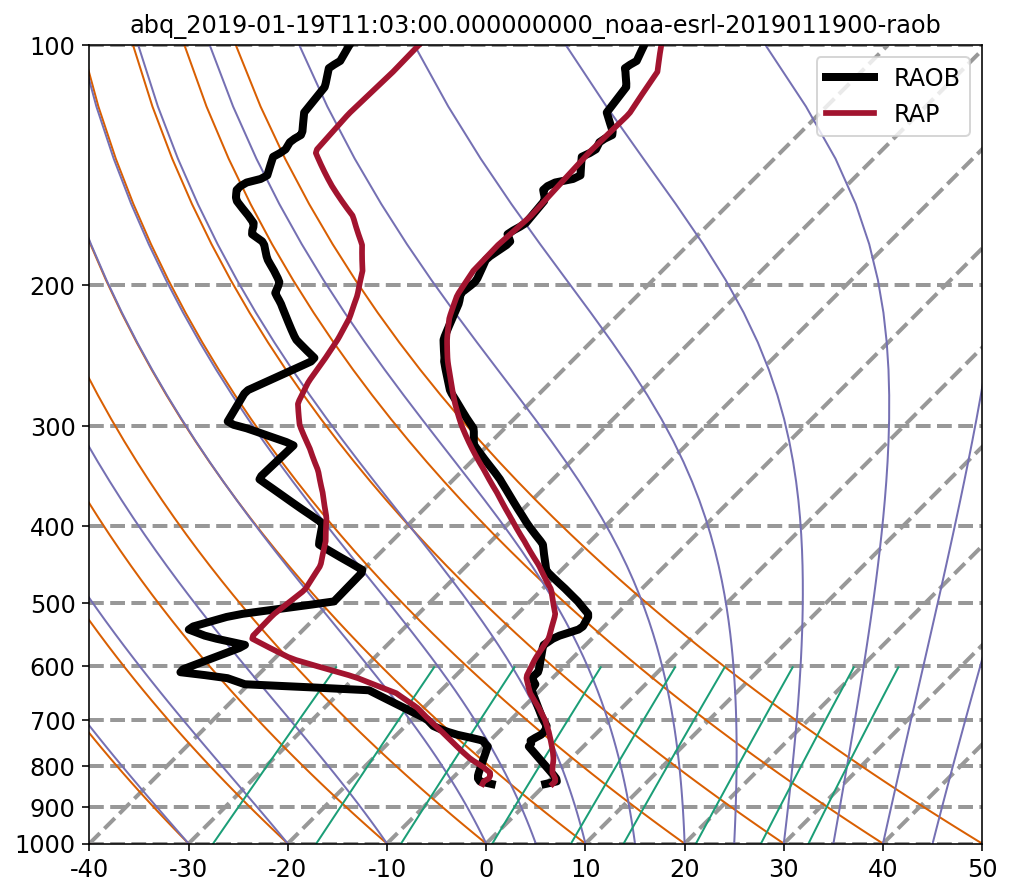

In [13]:
index = 10
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = rap[index,:,dl.PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = rap[index,:,dl.TEMPERATURE]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = raob[index,:,dl.DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = rap[index,:,dl.DEWPOINT]

title = sonde_files[index]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");

# RAP

- [Linear](#Linear-NN)
- [Fully Connected](#Fully-Connected-NN)
- [Conv1D NN](#Conv1D-NN)
- [CAE NN](#CAE-NN)
- [Transfer Learning RAOB](#Transfer-Learning-RAOB)

## Linear NN

### Temperature

In [40]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8, 0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.TEMPERATURE]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[dl.TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[dl.TEMPERATURE]].reshape(Ttest.shape[0],-1)

# Flatten inputs to (n, 3) and (n, 1) vectors
# input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT]
# Xt = Xtrain[:,:,input_dims]
# Xt = Xt.reshape(-1, Xt.shape[-1])
# Tt = Ttrain[:,:,[dl.TEMPERATURE]]
# Tt = Tt.reshape(-1, Tt.shape[-1])
# Xe = Xtest[:,:,input_dims]
# Xe = Xe.reshape(-1, Xe.shape[-1])
# Te = Ttest[:,:,[dl.TEMPERATURE]]
# Te = Te.reshape(-1, Te.shape[-1])

Xt.shape, Tt.shape, Xe.shape, Te.shape

((14038, 512), (14038, 256), (3510, 512), (3510, 256))

In [41]:
nnet = nn.NeuralNetwork(Xt.shape[1], [0], Tt.shape[1], activation='tanh', seed=1234)

nnet.model.summary()

nnet.train(Xt, Tt, 50, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xe, Te])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
Total params: 131,328
Trainable params: 131,328
Non-trainable params: 0
_________________________________________________________________
epoch: 0, rmse 1.17291, val_rmse 0.99656
epoch: 10, rmse 1.12887, val_rmse 0.99523


NeuralNetwork(512, [0], 256)
  Final objective value is 0.96433 in 3.2169 seconds.

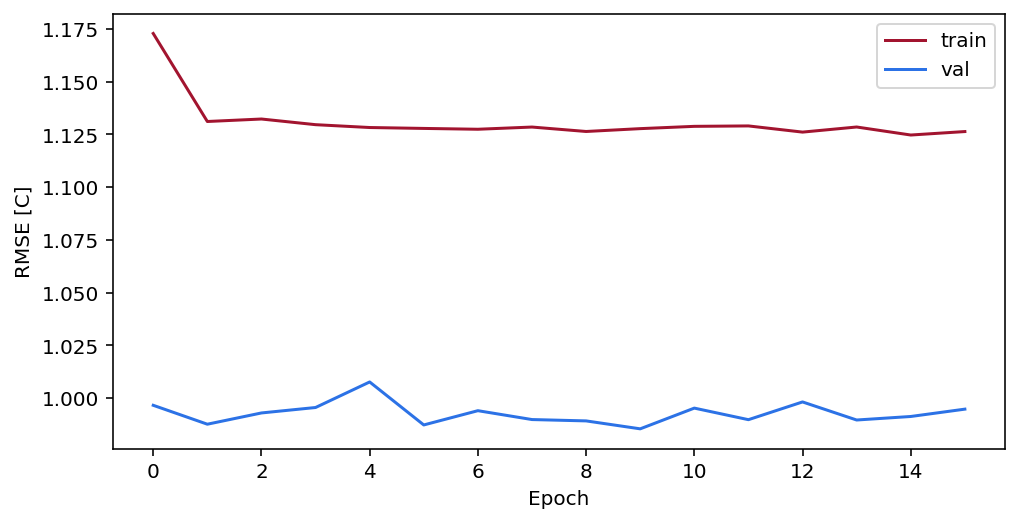

In [42]:
results.plot_loss(nnet)

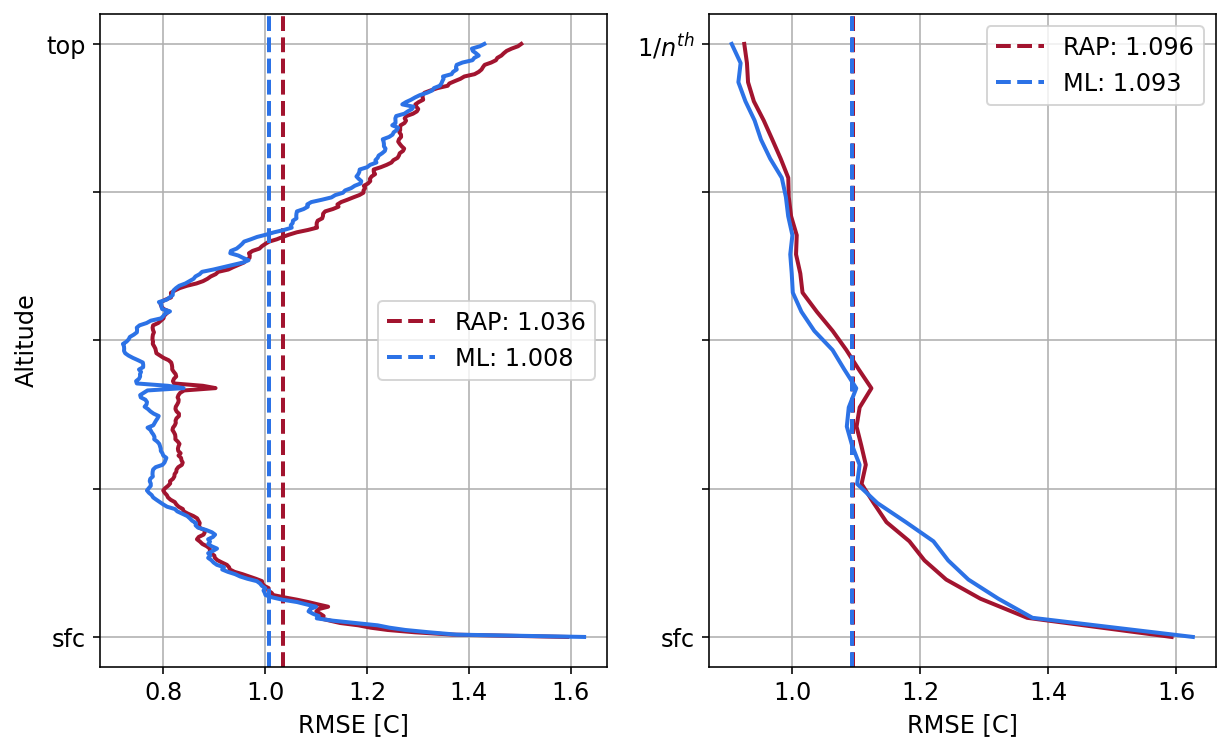

In [79]:
results.plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,dl.TEMPERATURE])

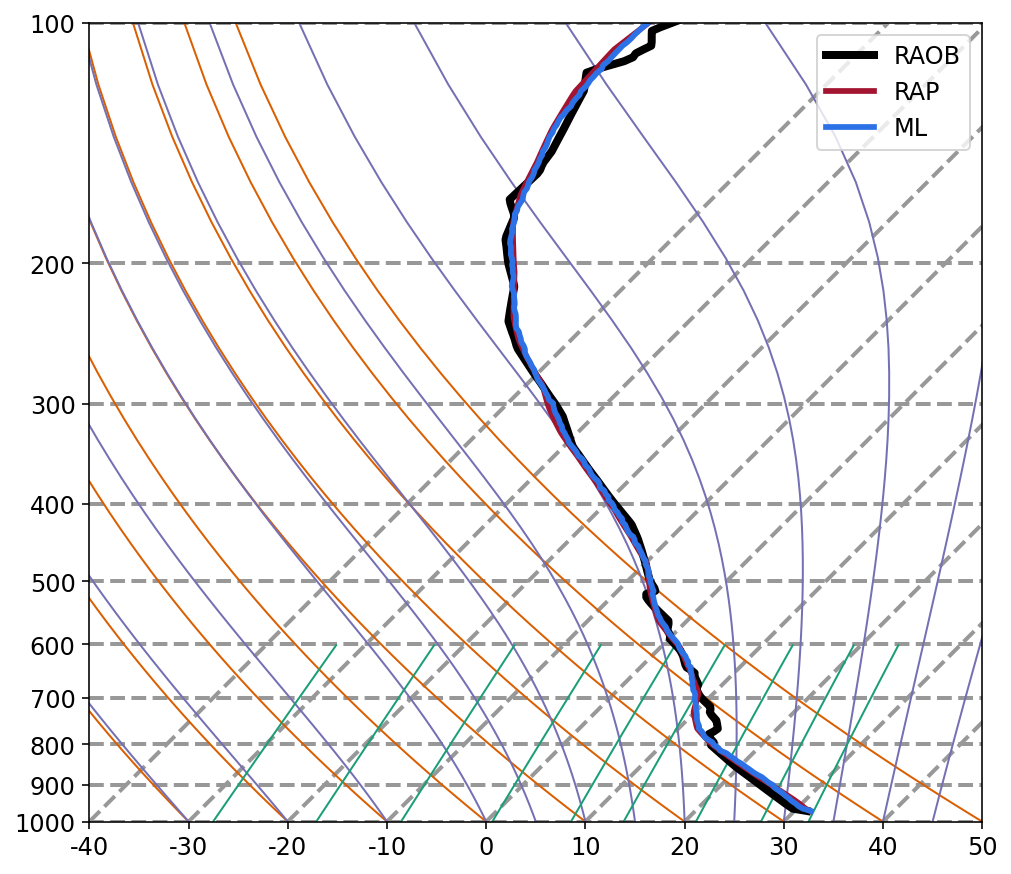

In [15]:
i = 11
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [15]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.DEWPOINT]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[dl.DEWPOINT]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[dl.DEWPOINT]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((1026, 512), (1026, 256), (257, 512), (257, 256))

In [16]:
nnet = nn.NeuralNetwork(Xt.shape[1], [0], Tt.shape[1], activation='tanh', seed=1234)

# nnet.model.summary()

nnet.train(Xt, Tt, 50, 32, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xe, Te])

epoch: 0, rmse 7.18426, val_rmse 5.21541
epoch: 5, rmse 4.11318, val_rmse 4.10166
epoch: 10, rmse 4.05034, val_rmse 4.00481
epoch: 15, rmse 4.11325, val_rmse 3.98300
epoch: 20, rmse 4.00335, val_rmse 4.10300
epoch: 25, rmse 3.99712, val_rmse 4.21545
epoch: 30, rmse 3.94755, val_rmse 3.88600
epoch: 35, rmse 3.95334, val_rmse 3.96296
epoch: 40, rmse 3.98814, val_rmse 3.95622
epoch: 45, rmse 4.03165, val_rmse 4.01923
epoch: 49, rmse 4.07442, val_rmse 4.03292
finished!


NeuralNetwork(512, [0], 256)
  Final objective value is 0.34936 in 3.7494 seconds.

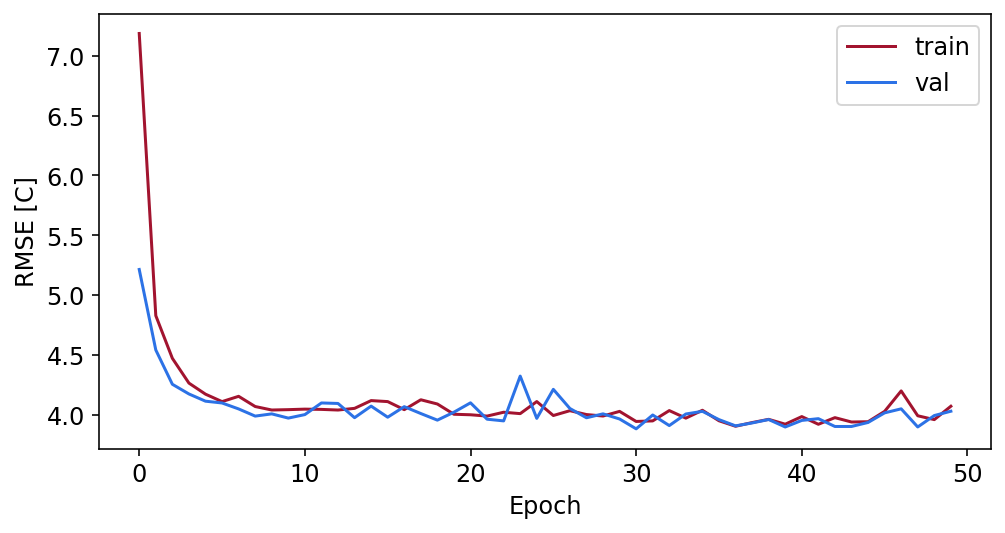

In [18]:
results.plot_loss(nnet)

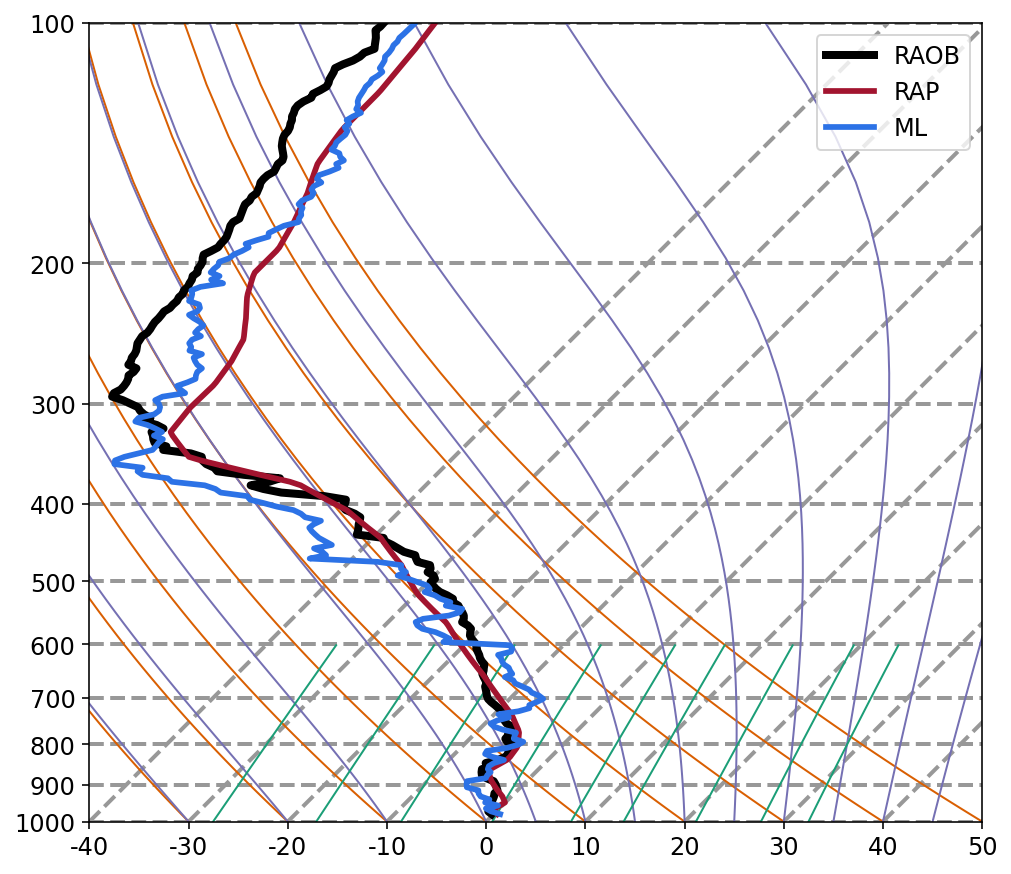

In [19]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.DEWPOINT]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

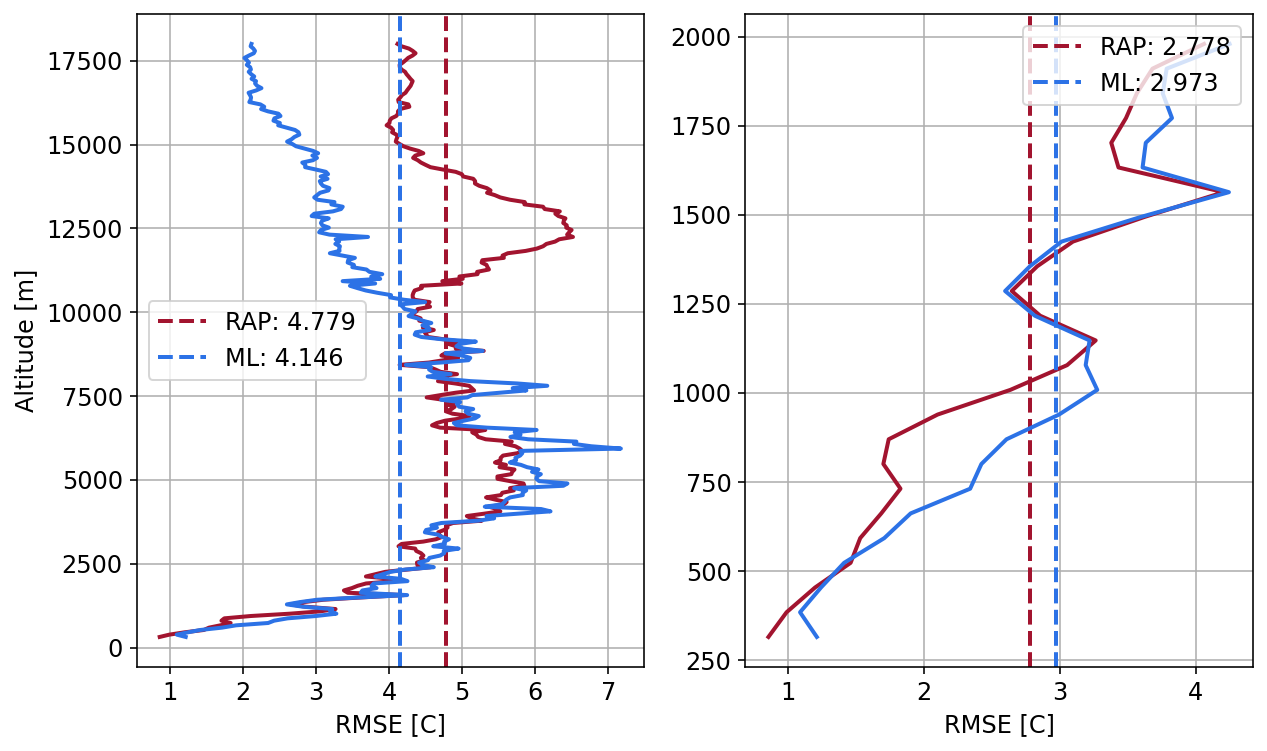

In [21]:
results.plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,dl.DEWPOINT], alt=raob[0, :, -1])

## Fully Connected NN

### Temperature

In [28]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT]
Xt = Xtrain[:,::128,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,::128,[dl.TEMPERATURE]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,::128,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,::128,[dl.TEMPERATURE]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((14038, 6), (14038, 2), (3510, 6), (3510, 2))

FloatProgress(value=0.0, max=8.0)

{'epochs': 100, 'batch_size': 32, 'method': 'adam', 'lr': 0.0005, 'activation': 'relu', 'layers': [32]}


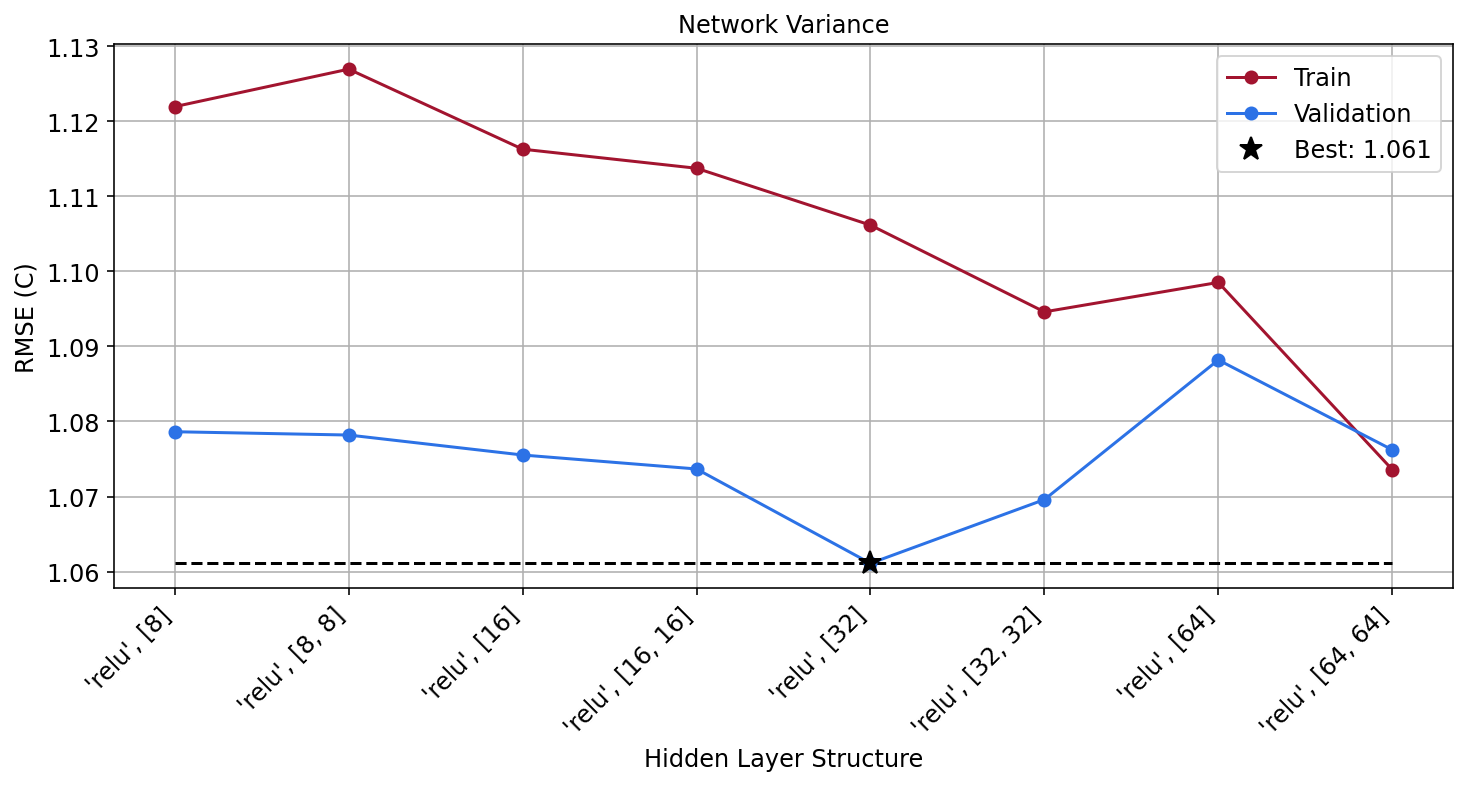

In [29]:
activations = ['relu']
layers = [[nu] * nl for nu in [8, 16, 32, 64] for nl in range(1, 3)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.NeuralNetwork, product, Xt, Tt, Xe, Te,
                                   epochs=100, batch_size=32, method='adam', lr=0.0005, verbose=False)
plot_param_search(product, train_history, val_history, rotation=45)

/home/stock/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stock/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stock/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stock/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

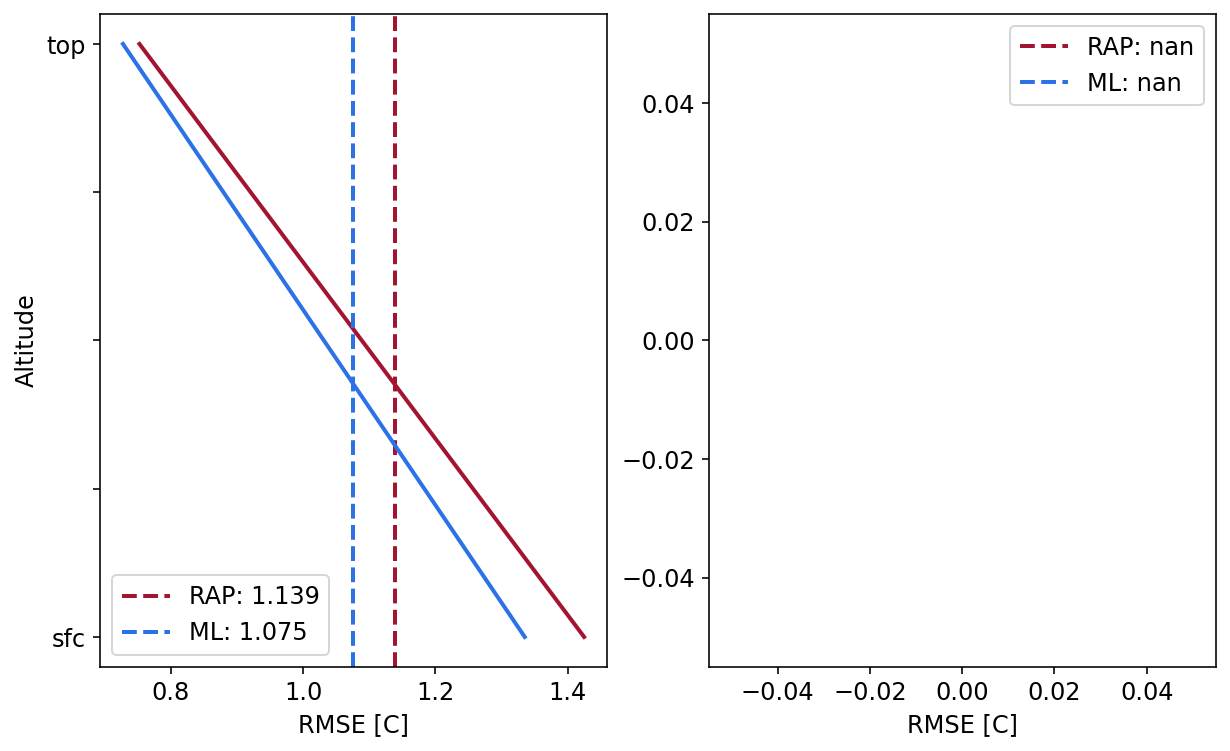

In [31]:
results.plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,dl.TEMPERATURE])

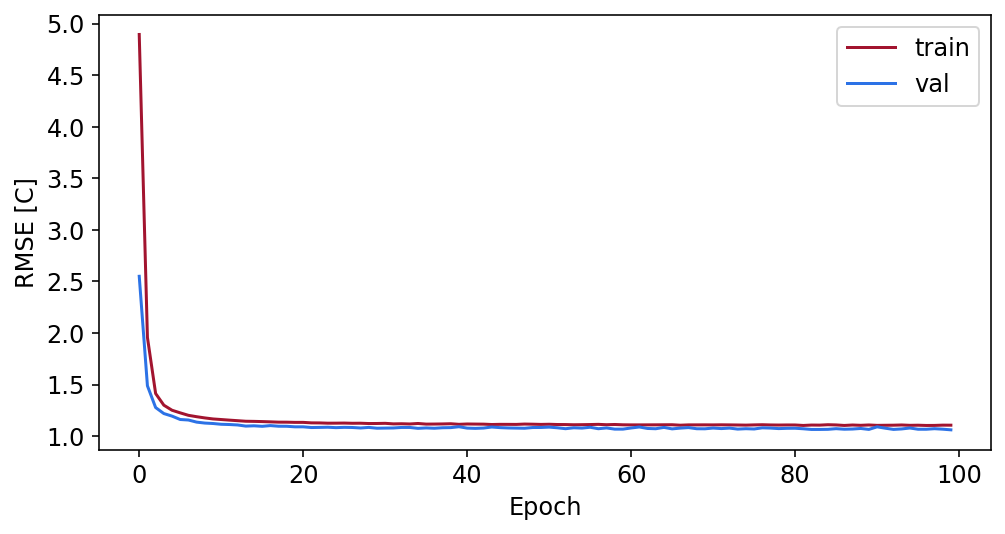

In [32]:
results.plot_loss(nnet)

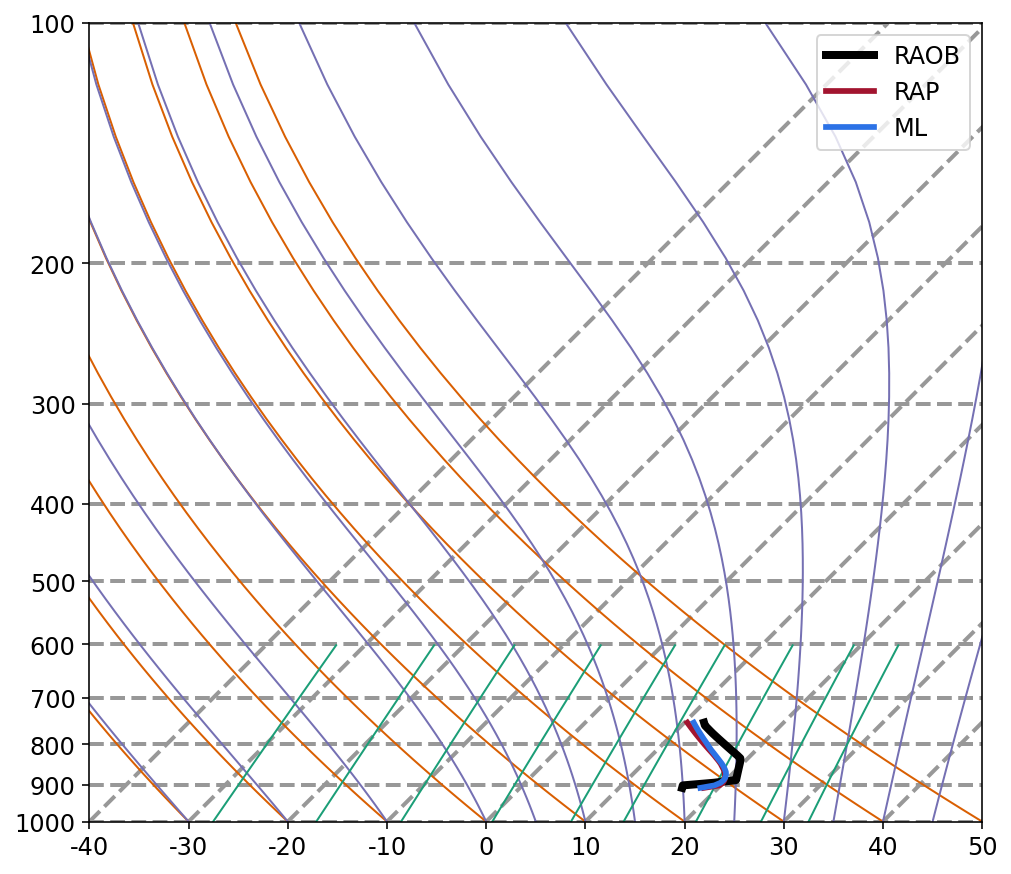

In [125]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i] # + Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0] # + Xtest[i,:,dl.TEMPERATURE]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [8]:
nnet = nn.NeuralNetwork(Xt.shape[1], [20]*20, Tt.shape[1], activation='relu')
nnet.train(Xt, Tt, 1000, 32, method='adam',
           verbose=True, learning_rate=0.001, validation=(Xe, Te))

epoch: 0, rmse 4.24383, val_rmse 3.54835
epoch: 40, rmse 2.13342, val_rmse 2.07583
epoch: 80, rmse 1.86274, val_rmse 1.83886
epoch: 120, rmse 1.78355, val_rmse 1.76985
epoch: 160, rmse 1.73952, val_rmse 1.76032
epoch: 199, rmse 1.71858, val_rmse 1.68852
finished!


NeuralNetwork(768, [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20], 256)
  Final objective value is 0.05966 in 498.3051 seconds.

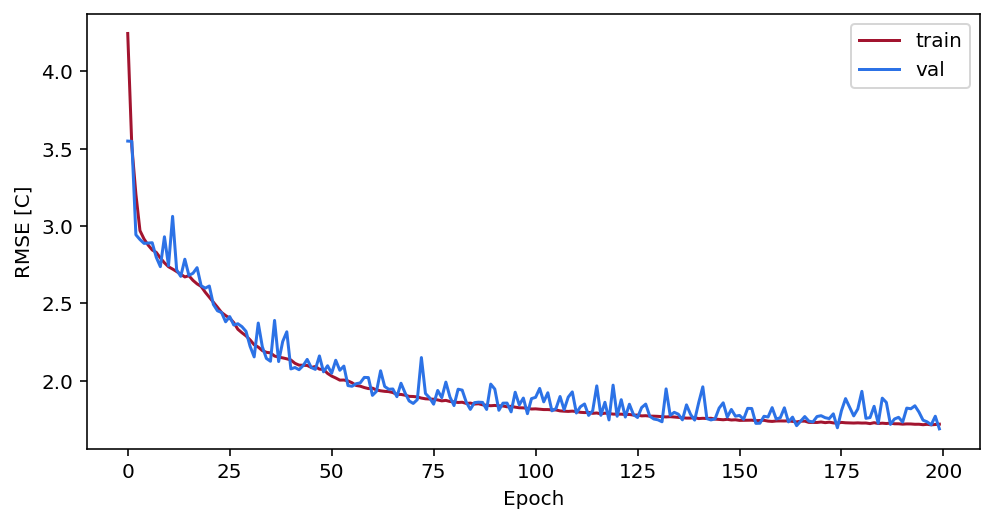

In [9]:
results.plot_loss(nnet)

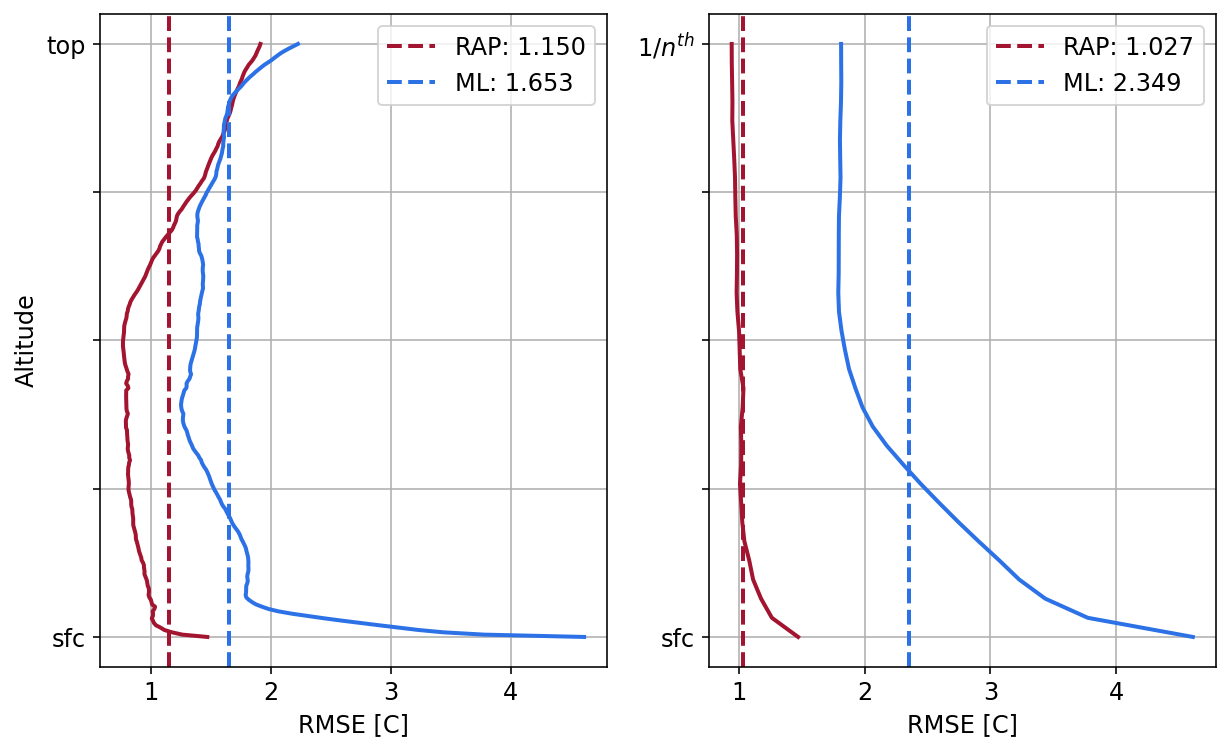

In [10]:
results.plot_altitude_rmse_verticle(nnet, Xt, Tt, Xtrain[:,:,dl.TEMPERATURE])

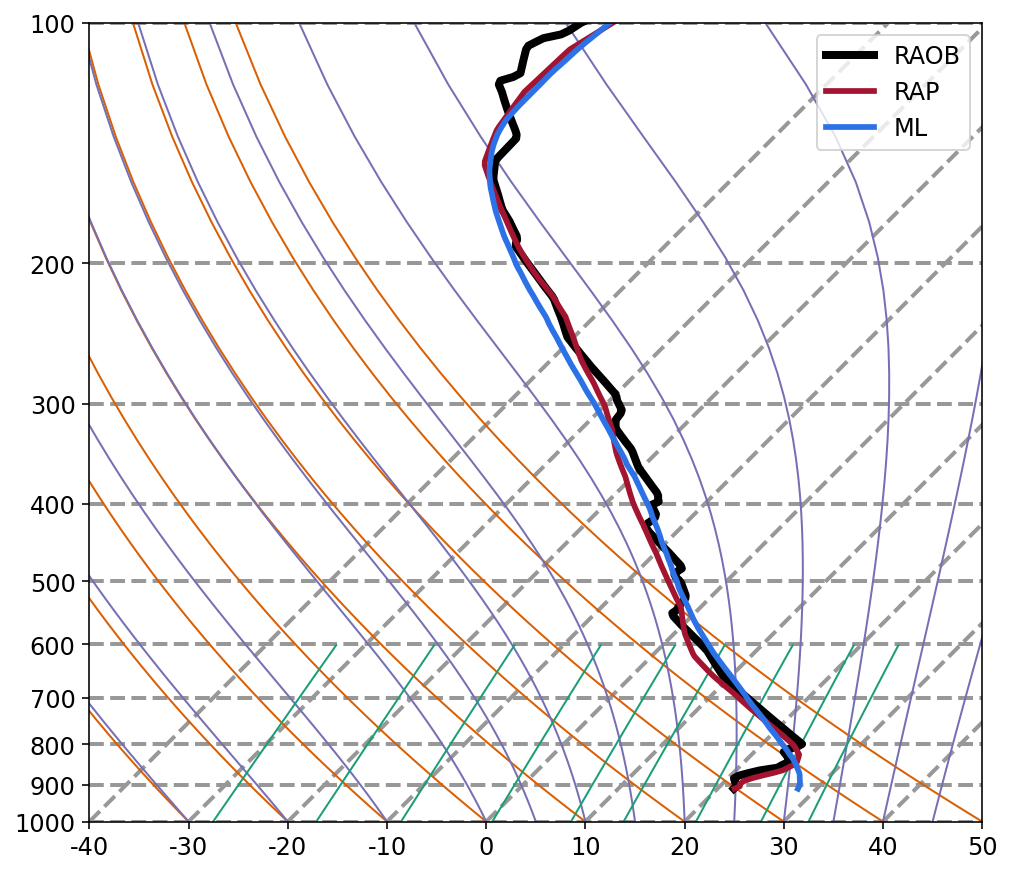

In [11]:
i = 5
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [27]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.DEWPOINT]
Xt = Xtrain[:,:,input_dims].reshape(Xtrain.shape[0],-1)
Tt = Ttrain[:,:,[dl.DEWPOINT]].reshape(Ttrain.shape[0],-1)
Xe = Xtest[:,:,input_dims].reshape(Xtest.shape[0],-1)
Te = Ttest[:,:,[dl.DEWPOINT]].reshape(Ttest.shape[0],-1)

Xt.shape, Tt.shape, Xe.shape, Te.shape

((1026, 512), (1026, 256), (257, 512), (257, 256))

FloatProgress(value=0.0, max=18.0)

{'epochs': 50, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'relu', 'layers': [128]}


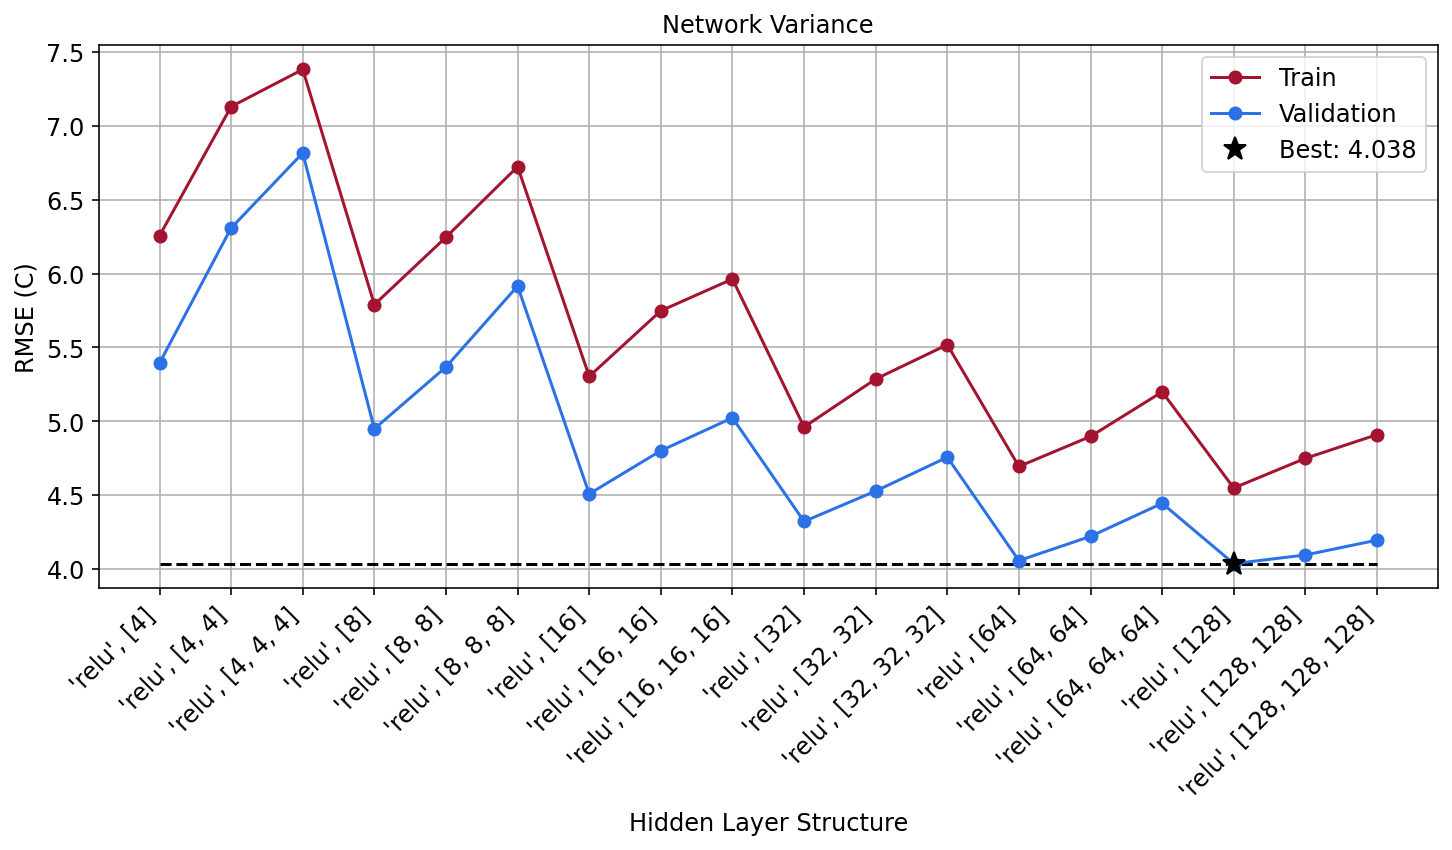

In [28]:
activations = ['relu']
layers = [[nu] * nl for nu in [4, 8, 16, 32, 64, 128] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.NeuralNetwork, product, Xt, Tt, Xe, Te,
                                   epochs=50, batch_size=32, method='adam', lr=0.001, verbose=False)
plot_param_search(product, train_history, val_history, rotation=45)

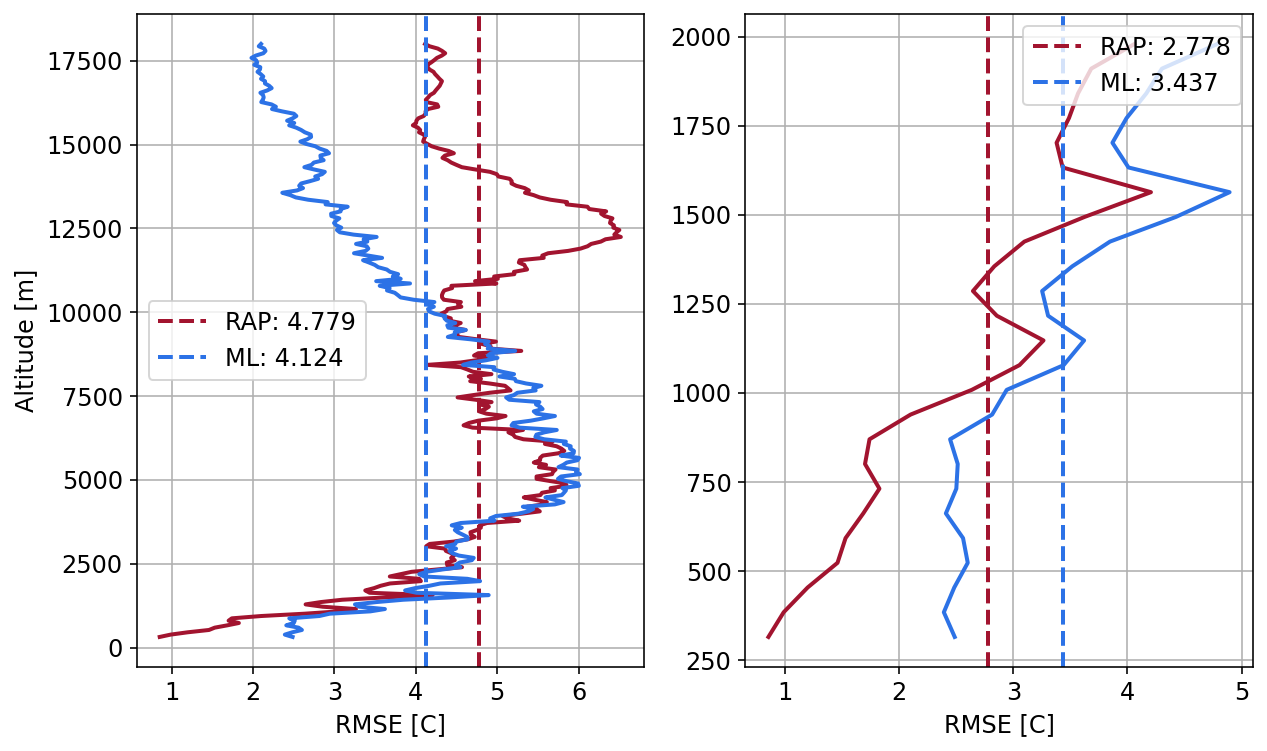

In [29]:
results.plot_altitude_rmse_verticle(nnet, Xe, Te, Xtest[:,:,dl.DEWPOINT], alt=raob[0, :, -1])

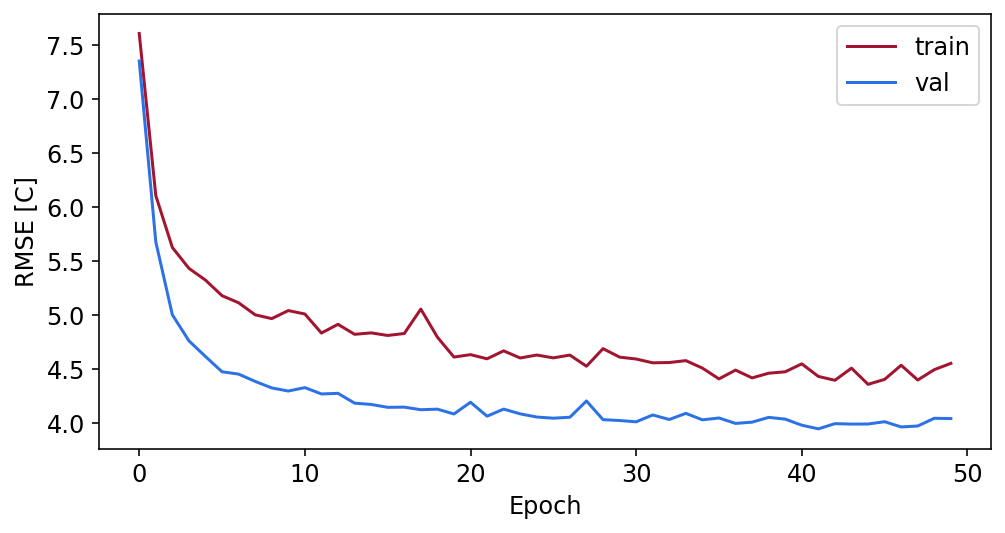

In [30]:
results.plot_loss(nnet)

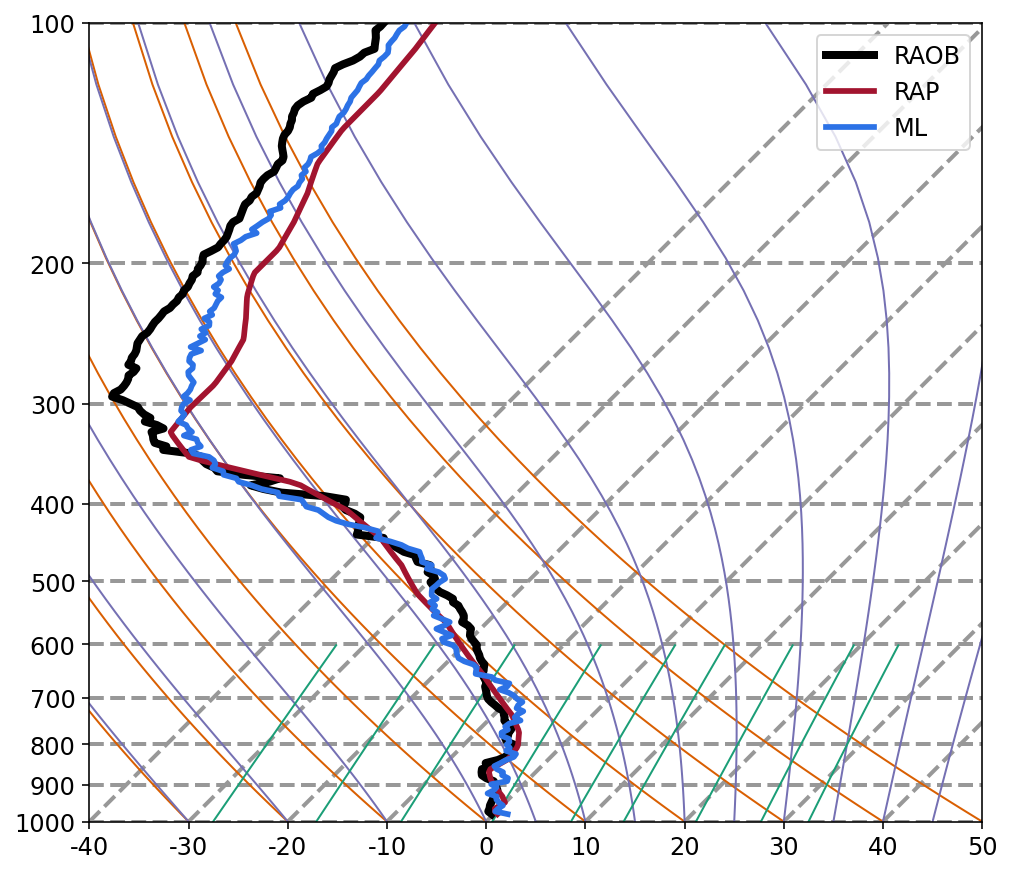

In [31]:
i = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Te[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.DEWPOINT]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xe[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Conv1D NN

### Temperature

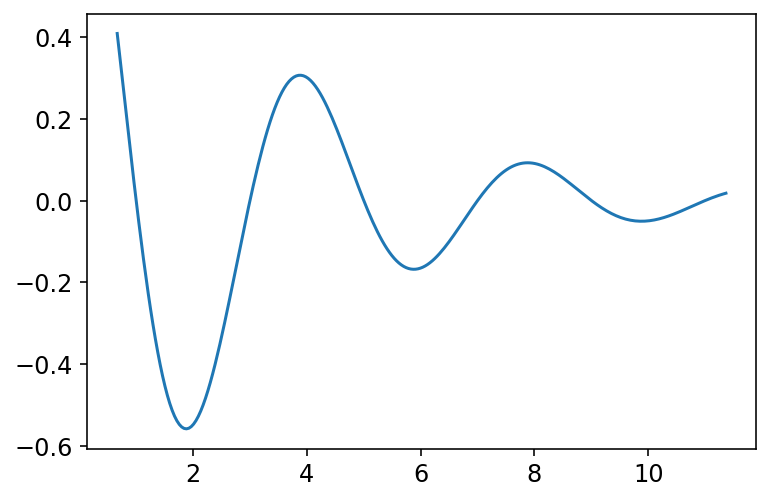

In [204]:
x = np.linspace(np.random.uniform(-4, 4), np.random.uniform(5, 15), 256)
deflection = np.random.randint(1, 5)
damping_coefficent = 0.3
w = 0.5*np.pi
el = deflection * np.exp(-x*damping_coefficent) * np.cos(w * x)
plt.plot(x, el)

In [182]:
def perturb(X, T, shuffle=True):
    temp = copy.copy(X)
    for i in range(len(temp)):
        x = np.linspace(np.random.uniform(-4, 4), np.random.uniform(9, 15), X.shape[1])
        deflection = np.random.randint(1, 5)
        damping_coefficent = 0.3
        w = 0.5*np.pi
        temp[i,:,dl.TEMPERATURE] += deflection * np.exp(-x*damping_coefficent) * np.cos(w * x)

    X = np.concatenate([X, temp])
    T = np.concatenate([T, T])
    
    if shuffle:
        rowIndices = np.arange(len(X))
        np.random.shuffle(rowIndices)
        X = X[rowIndices]
        T = T[rowIndices]
    
    return X, T

In [25]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

# for i in range(2):
#     Xtrain, Ttrain = perturb(Xtrain, Ttrain)

input_dims = [dl.PRESSURE, dl.TEMPERATURE, dl.DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.TEMPERATURE] # - Xtrain[:,:,dl.TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.TEMPERATURE] # - Xtest[:,:,dl.TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((14038, 2, 3), (14038, 2), (3510, 2, 3), (3510, 2))

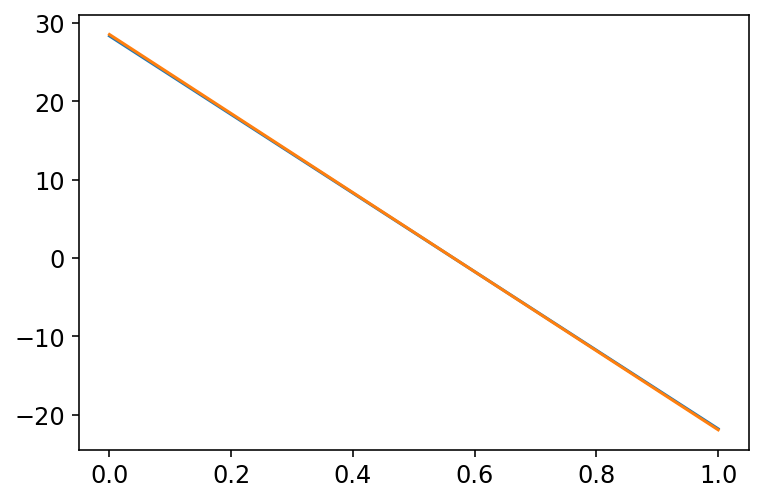

In [26]:
i = 1
plt.plot(Xtest[i, :, 1])
plt.plot(Ttest[i])

In [27]:
activations = ['tanh']
layers = [[128, 64, 32], [32, 64, 128]] + [[nu] * nl for nu in [8, 16, 32, 64, 128] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalNeuralNetwork, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=30, batch_size=64, method='adam', lr=0.001,
                                                kernels_size_and_stride=[[8, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

FloatProgress(value=0.0, max=17.0)

ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling1d_1/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](max_pooling1d_1/ExpandDims)' with input shapes: [?,1,1,64].

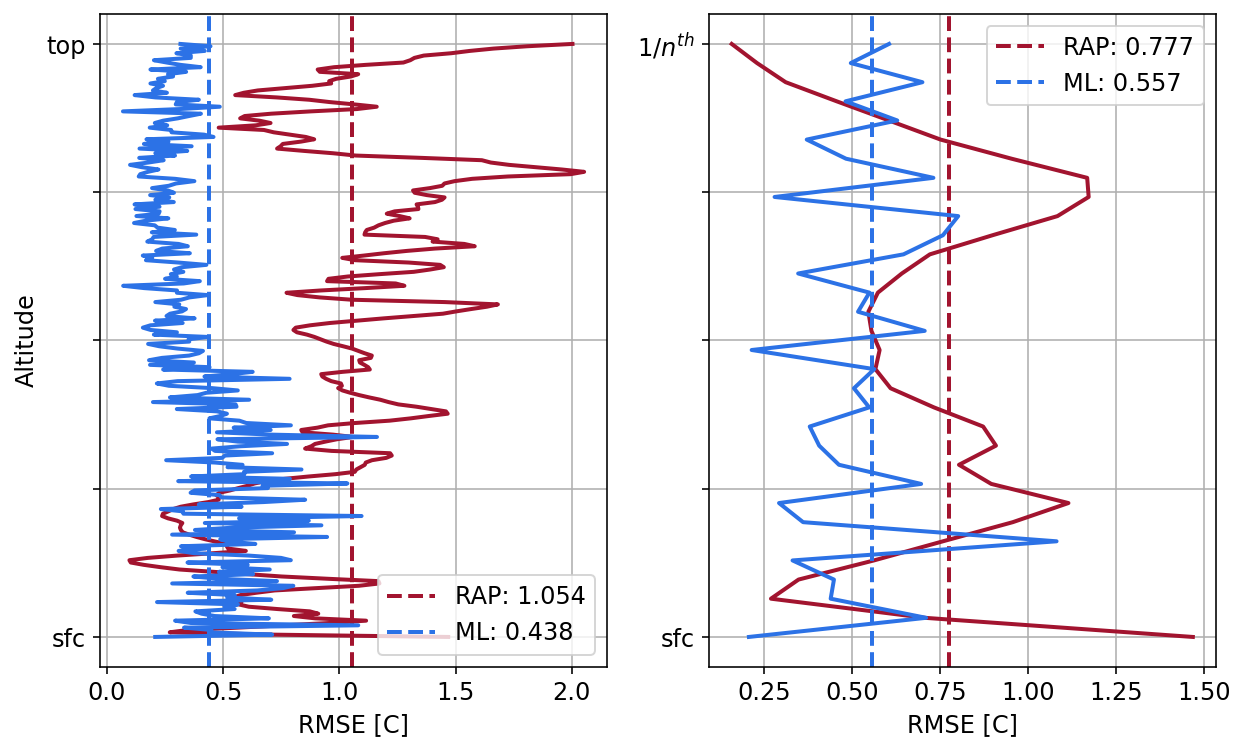

In [22]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,1])

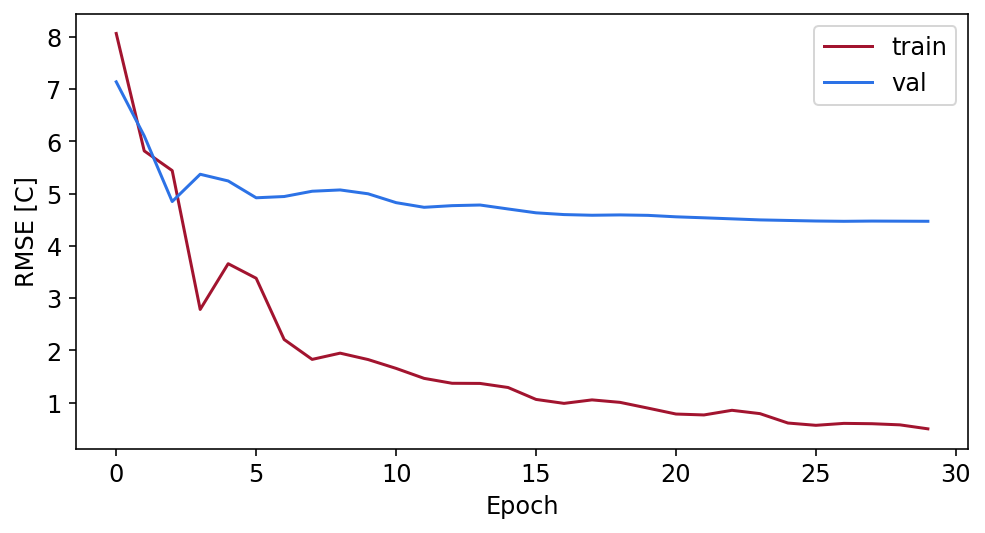

In [23]:
results.plot_loss(nnet)

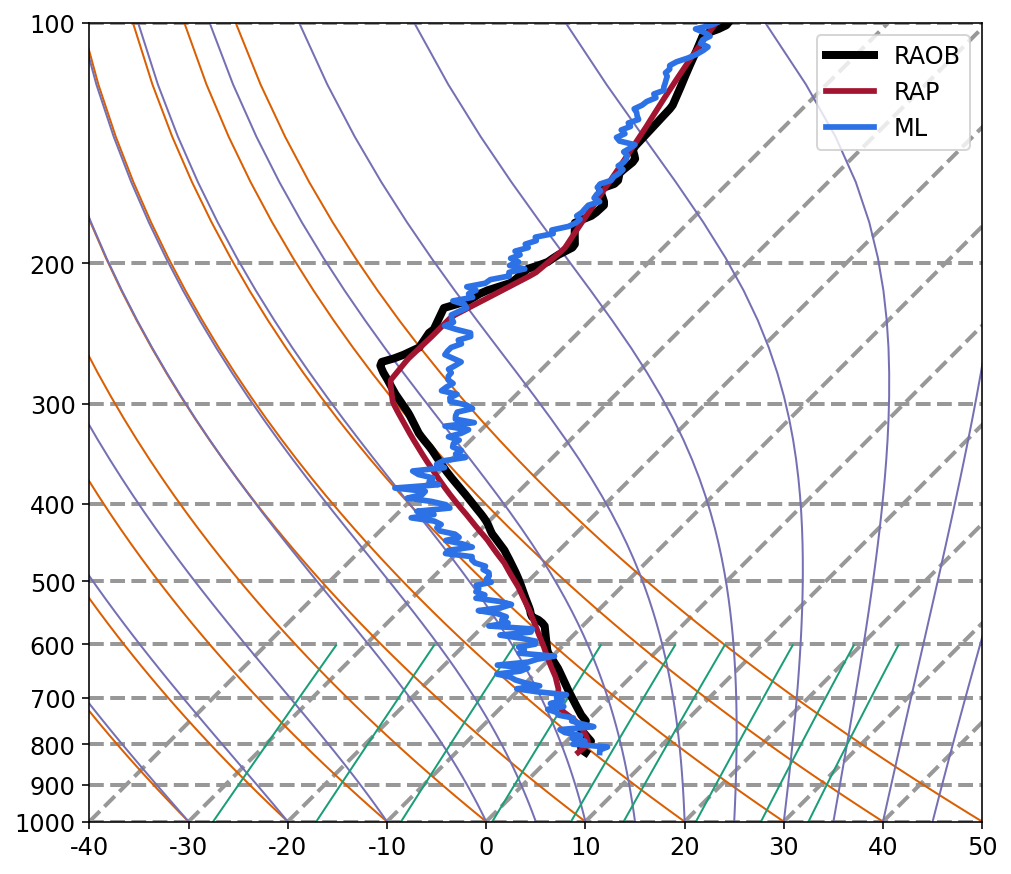

In [24]:
i = 4
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i] # + Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE] 
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0] # + Xtest[i,:,dl.TEMPERATURE]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

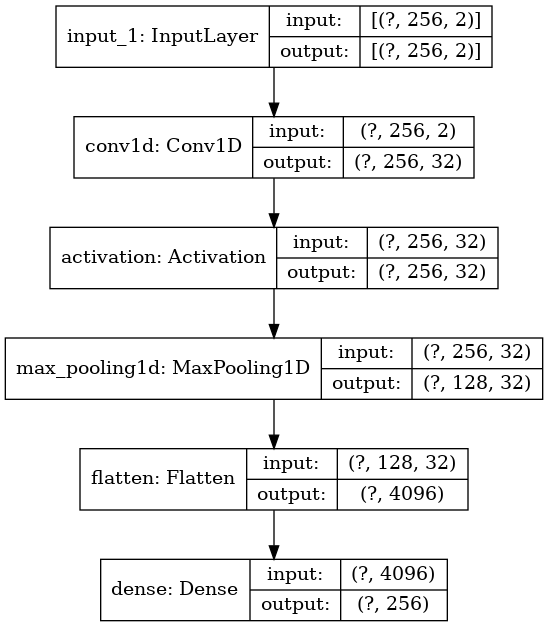

In [38]:
tf.keras.utils.plot_model(nnet.model, '/home/stock/research/media/rap_only_network.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

### Moisture

In [39]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.DEWPOINT]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.DEWPOINT]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 2), (1026, 256), (257, 256, 2), (257, 256))

FloatProgress(value=0.0, max=17.0)

{'epochs': 25, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [16]}


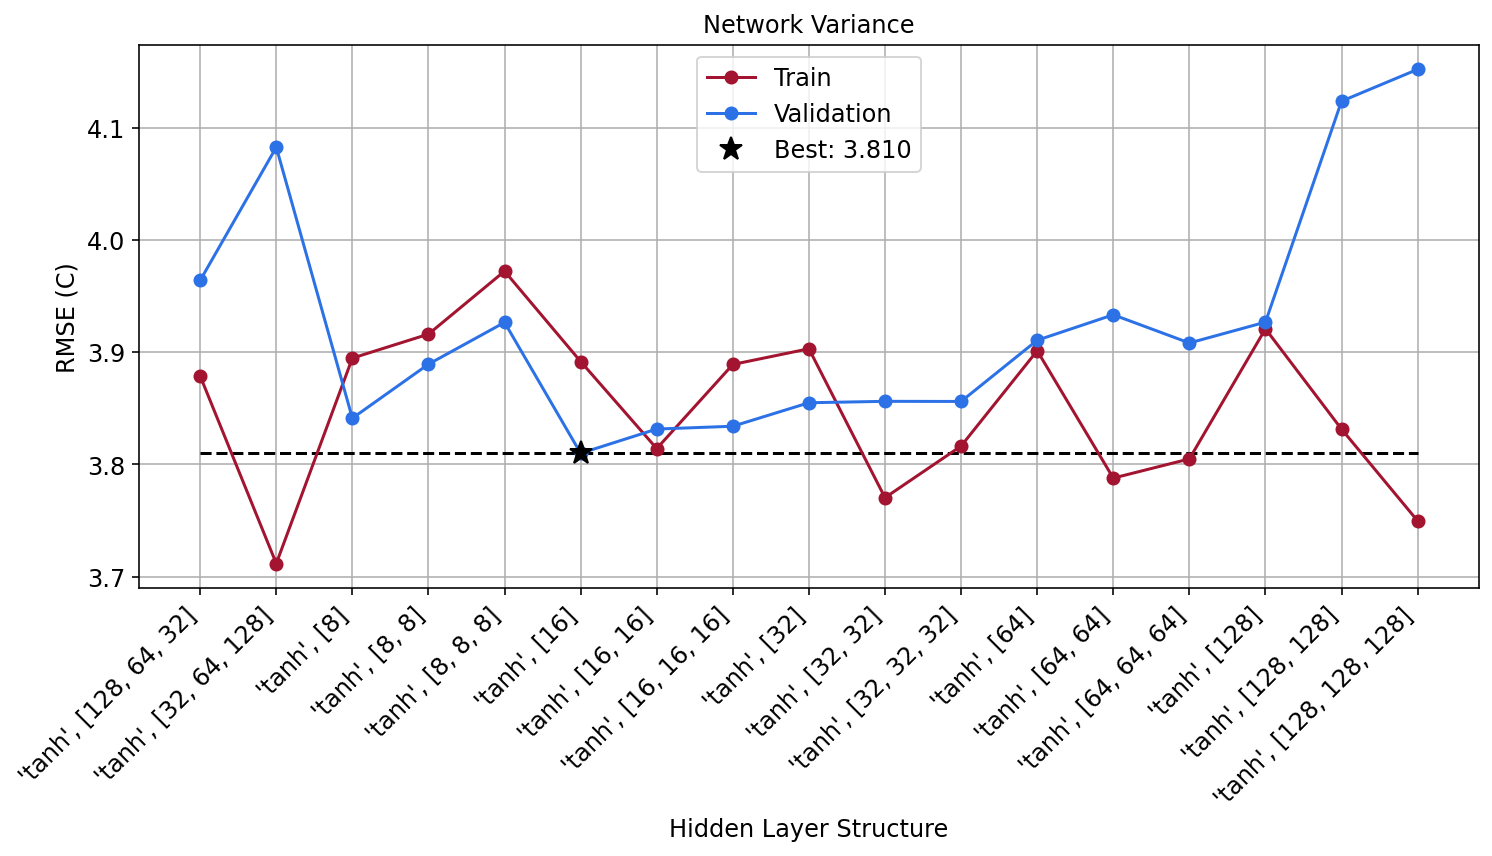

In [40]:
activations = ['tanh']
layers = [[128, 64, 32], [32, 64, 128]] + [[nu] * nl for nu in [8, 16, 32, 64, 128] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalNeuralNetwork, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=25, batch_size=32, method='adam', lr=0.001,
                                                kernels_size_and_stride=[[10, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

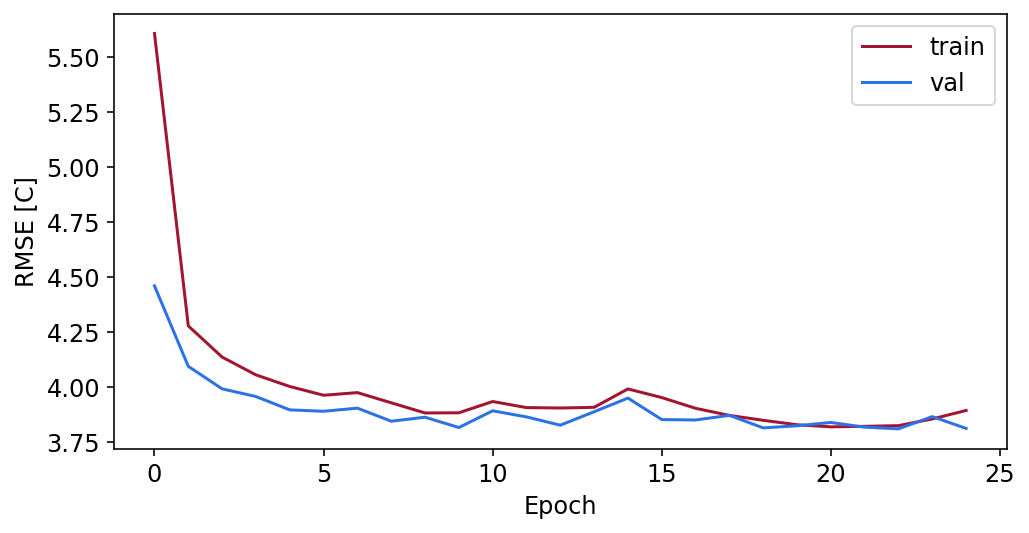

In [41]:
results.plot_loss(nnet)

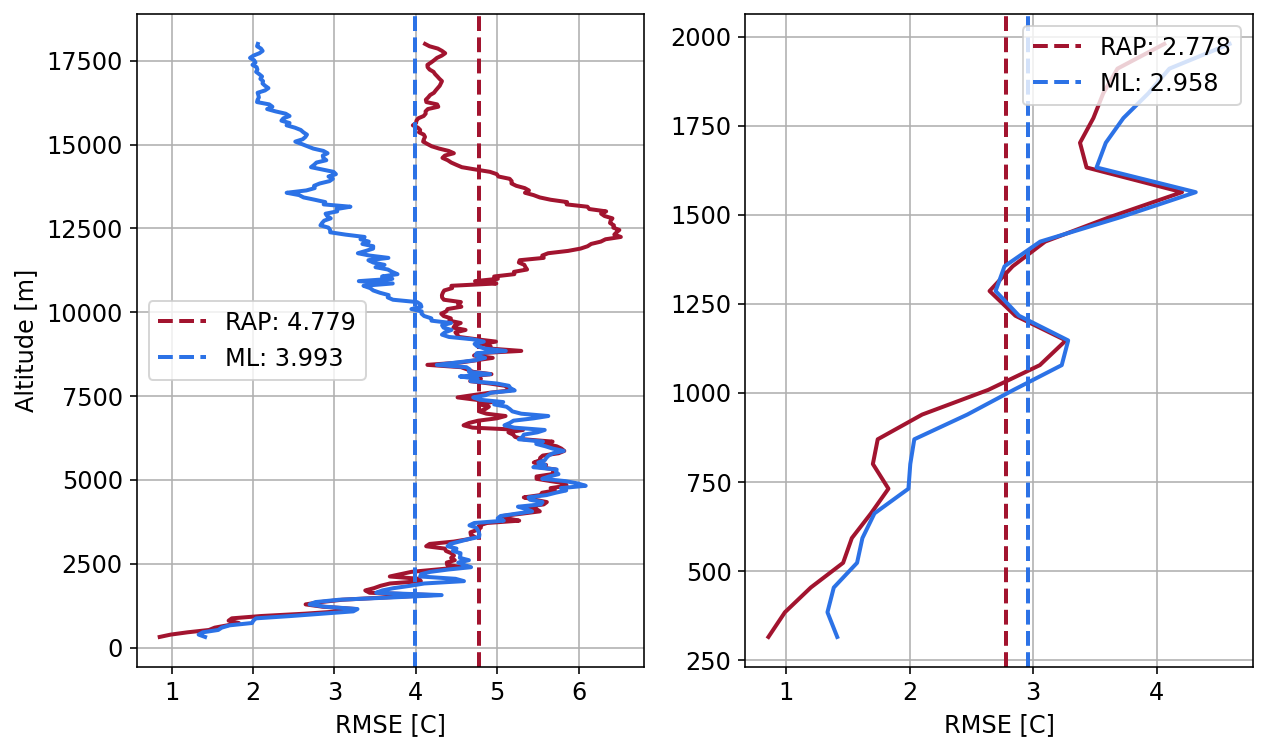

In [42]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])

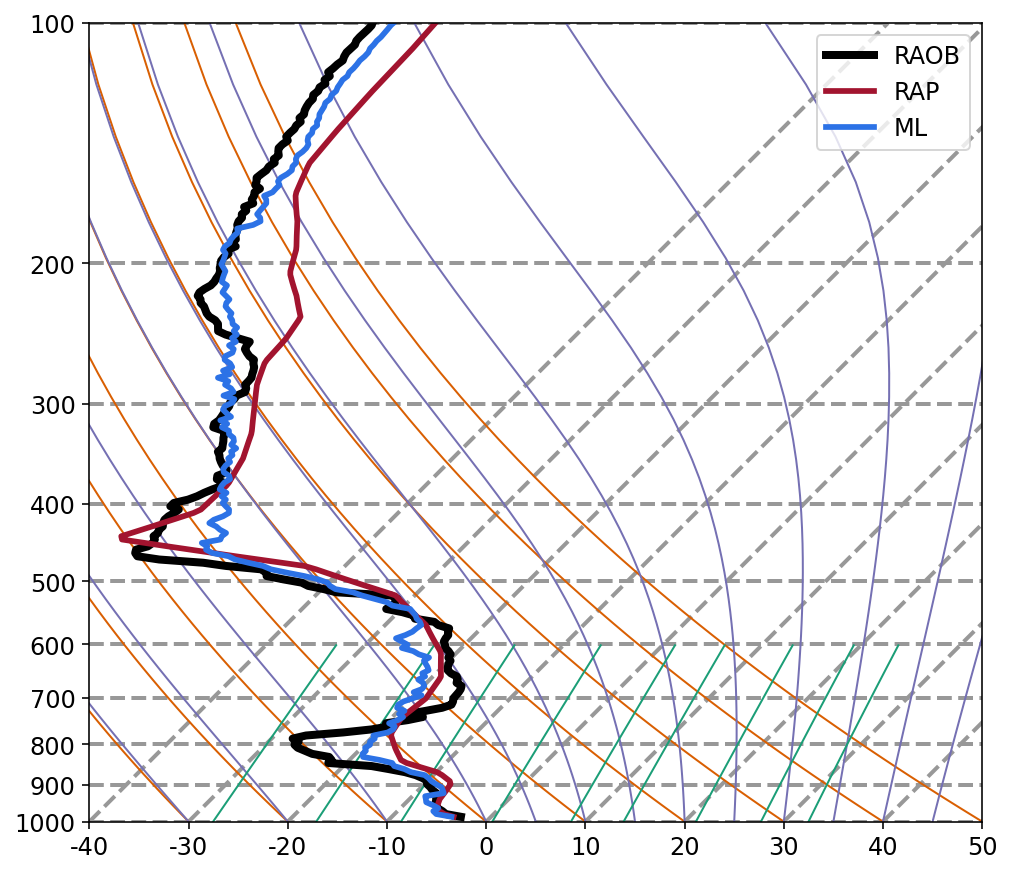

In [43]:
i = 0
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtrain[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtrain[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## CAE NN

### Temperature

In [12]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

input_dims = [dl.PRESSURE, dl.TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((14038, 256, 2), (14038, 256), (3510, 256, 2), (3510, 256))

FloatProgress(value=0.0, max=12.0)

{'epochs': 35, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'relu', 'layers': [16]}


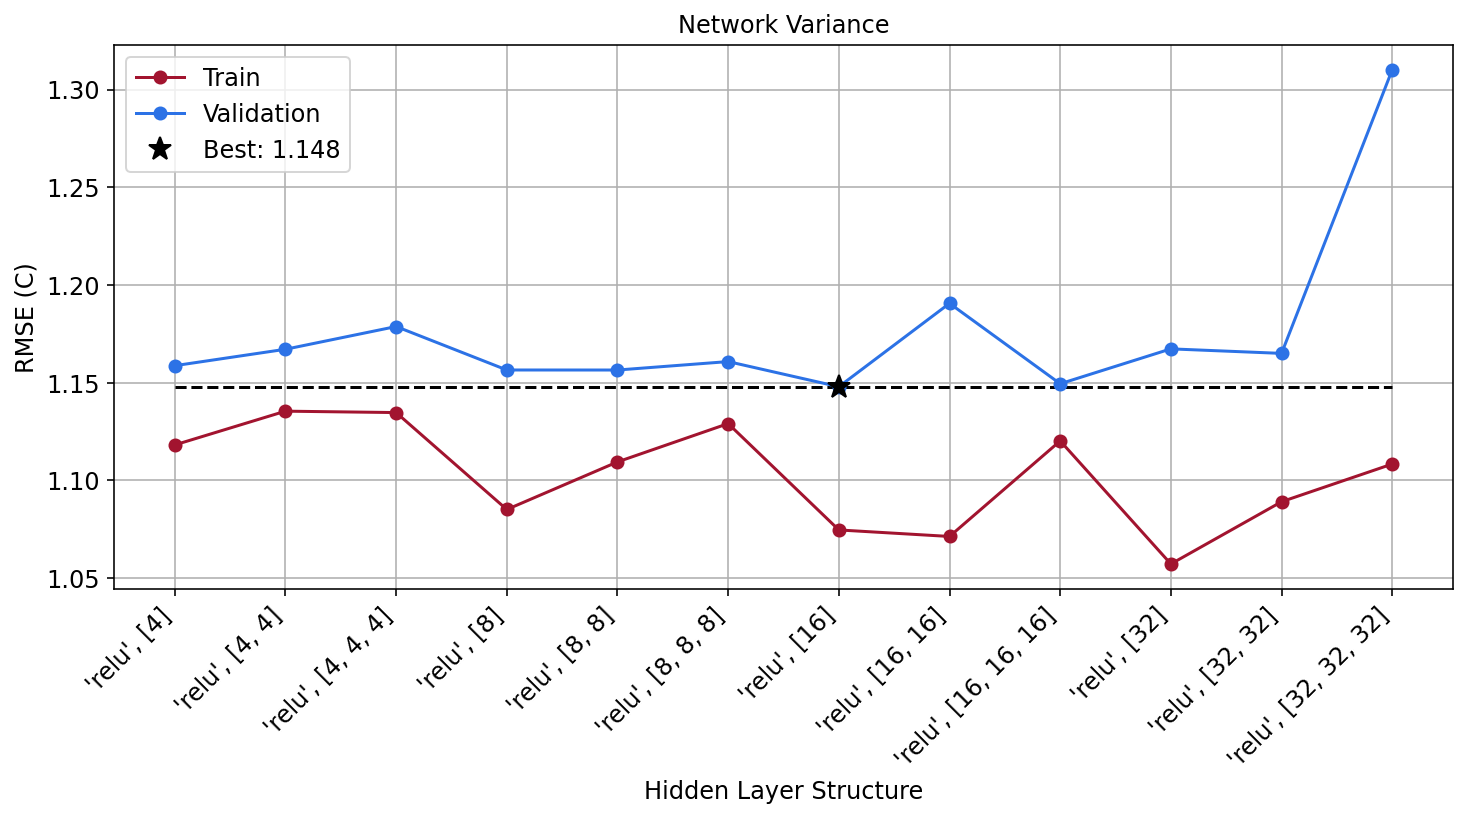

In [13]:
activations = ['relu']
layers = [[nu] * nl for nu in [4, 8, 16, 32] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalAutoEncoder, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=35, batch_size=32, method='adam',
                                                lr=0.001, kernels_size_and_stride=[[10, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

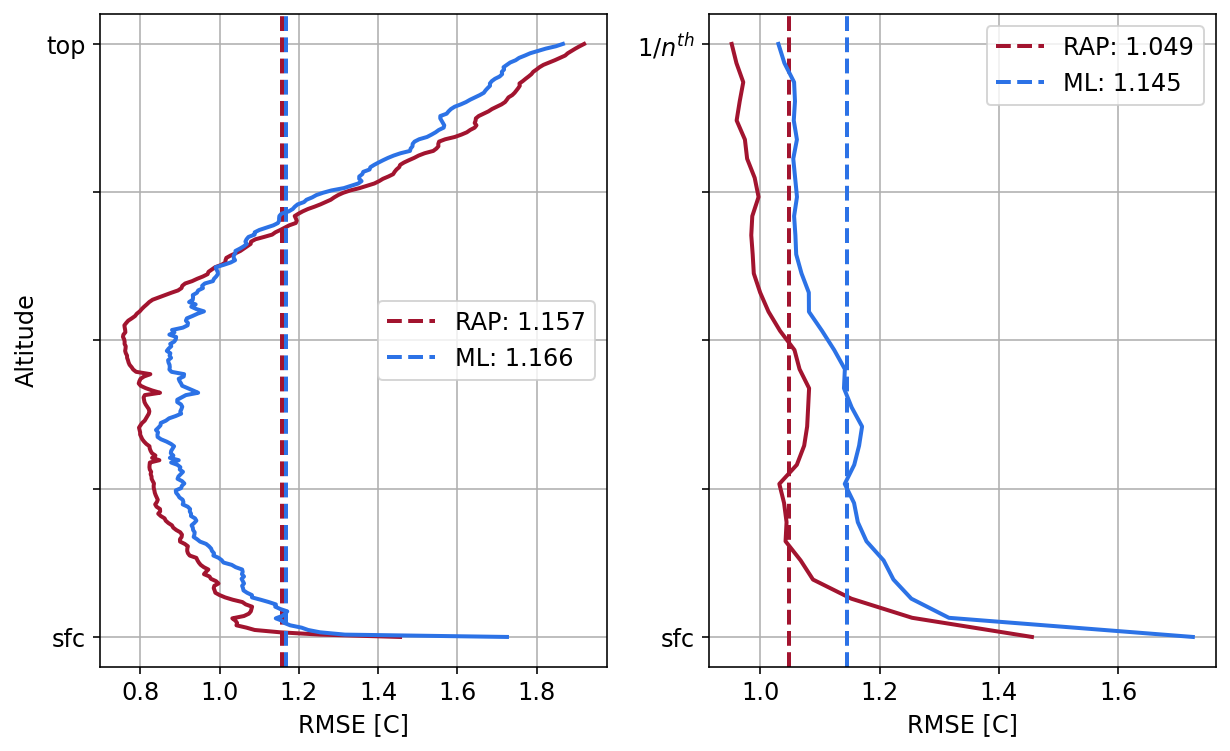

In [14]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,dl.TEMPERATURE], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

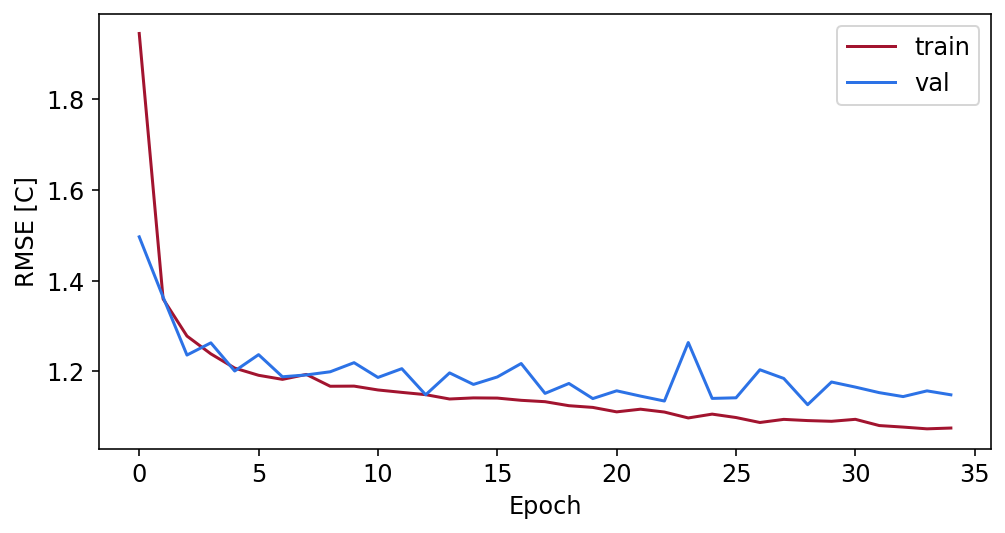

In [15]:
results.plot_loss(nnet)

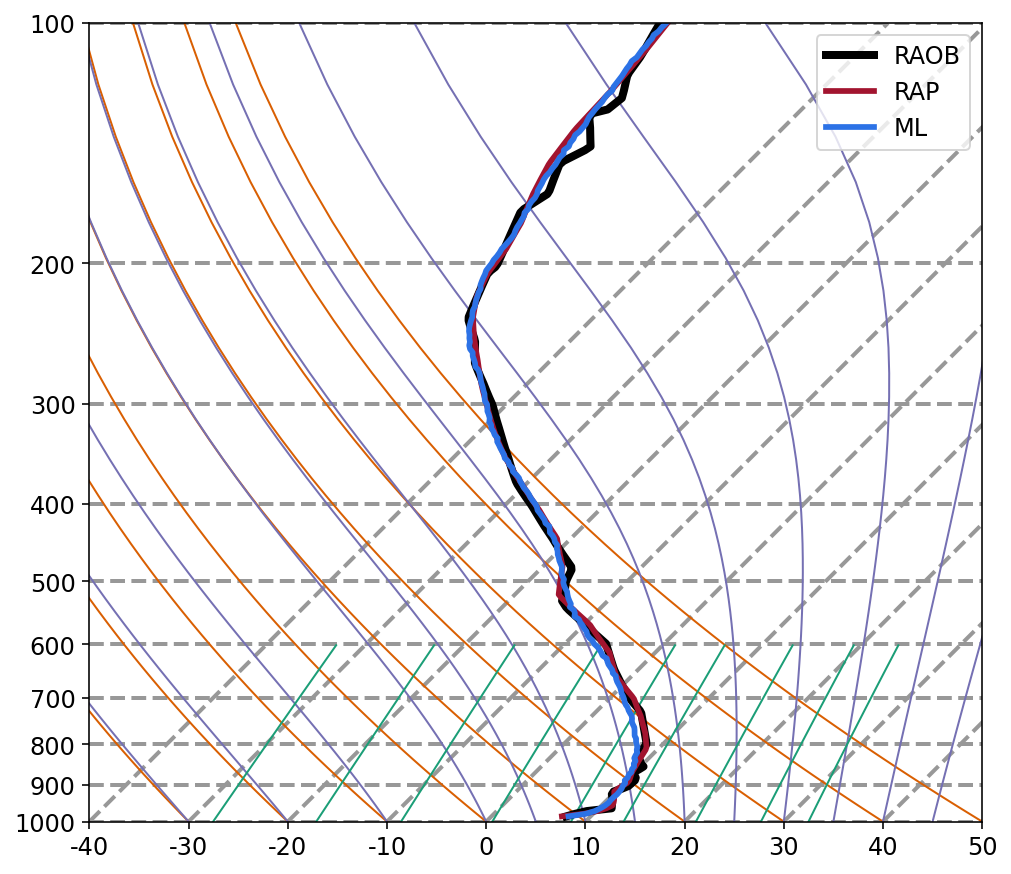

In [16]:
i = 4
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [49]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.DEWPOINT]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.DEWPOINT]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 2), (1026, 256), (257, 256, 2), (257, 256))

FloatProgress(value=0.0, max=12.0)

{'epochs': 35, 'batch_size': 32, 'method': 'adam', 'lr': 0.001, 'activation': 'tanh', 'layers': [4, 4, 4]}


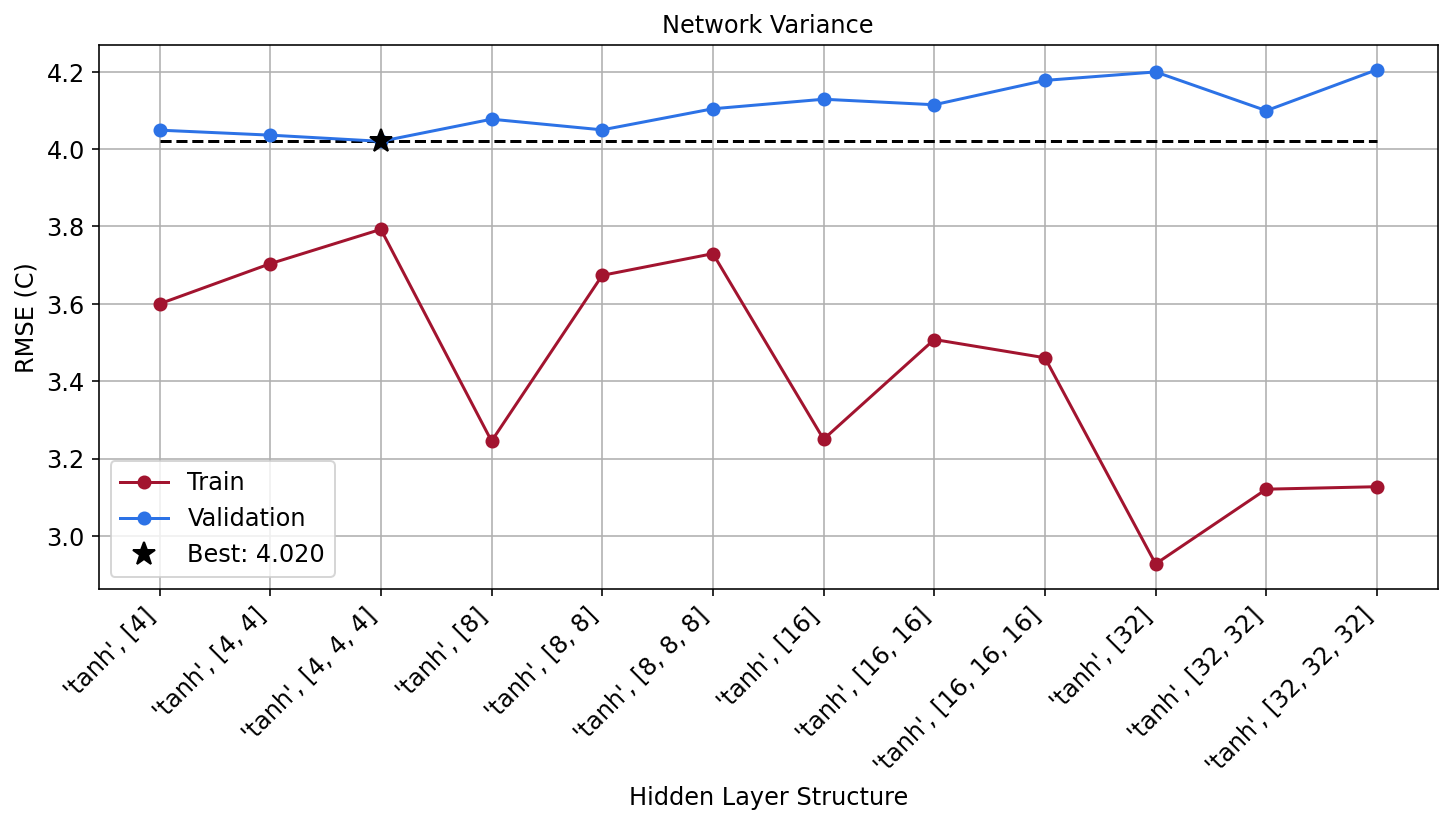

In [50]:
activations = ['tanh']
layers = [[nu] * nl for nu in [4, 8, 16, 32] for nl in range(1, 4)]
product = list(itertools.product(activations, layers))

nnet, train_history, val_history = param_search(nn.ConvolutionalAutoEncoder, product,
                                                Xtrain, Ttrain, Xtest, Ttest,
                                                epochs=35, batch_size=32, method='adam',
                                                lr=0.001, kernels_size_and_stride=[[10, 1]])
plot_param_search(product, train_history, val_history, rotation=45)

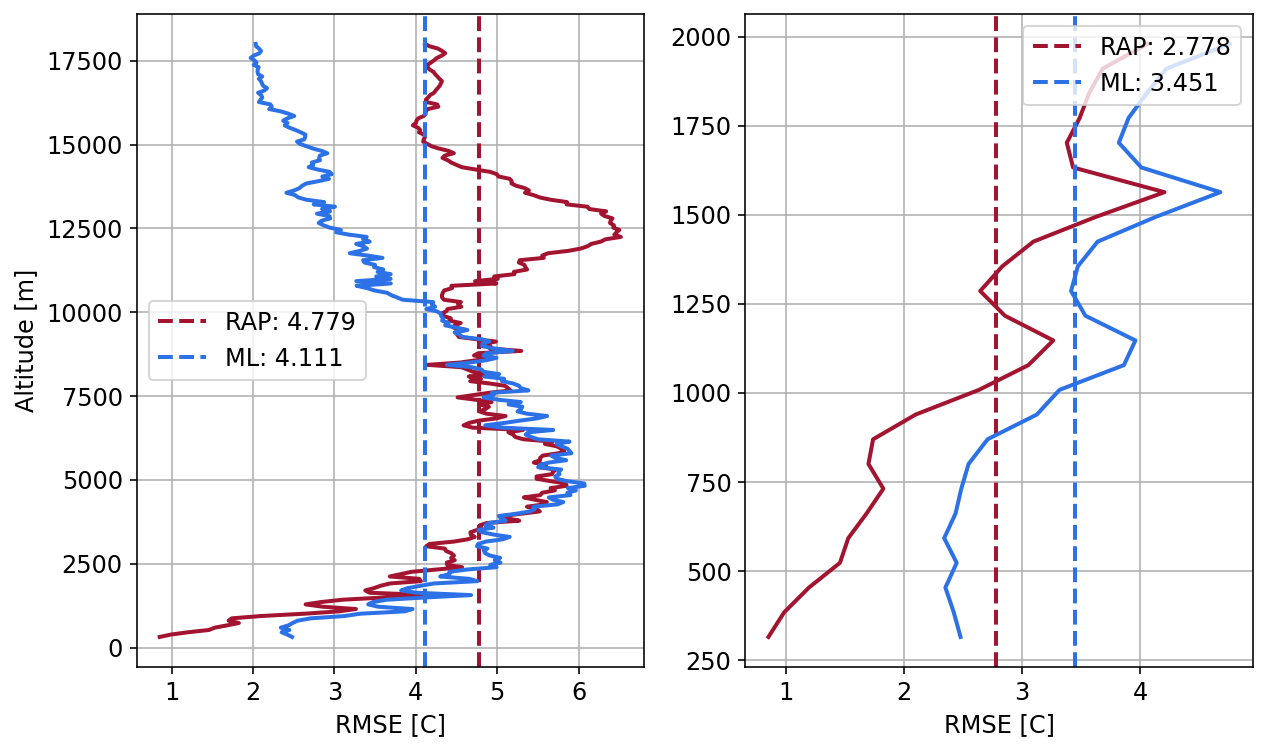

In [51]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

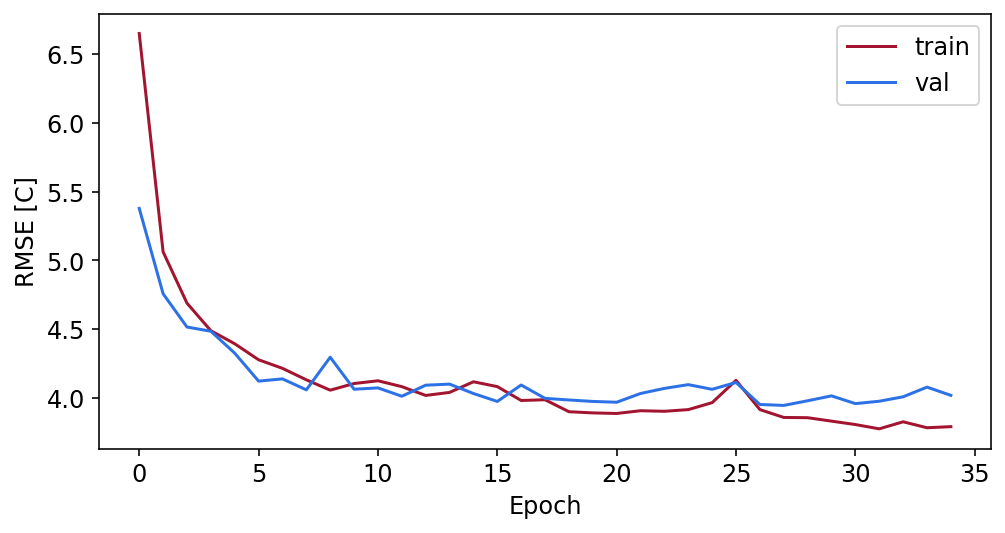

In [52]:
results.plot_loss(nnet)

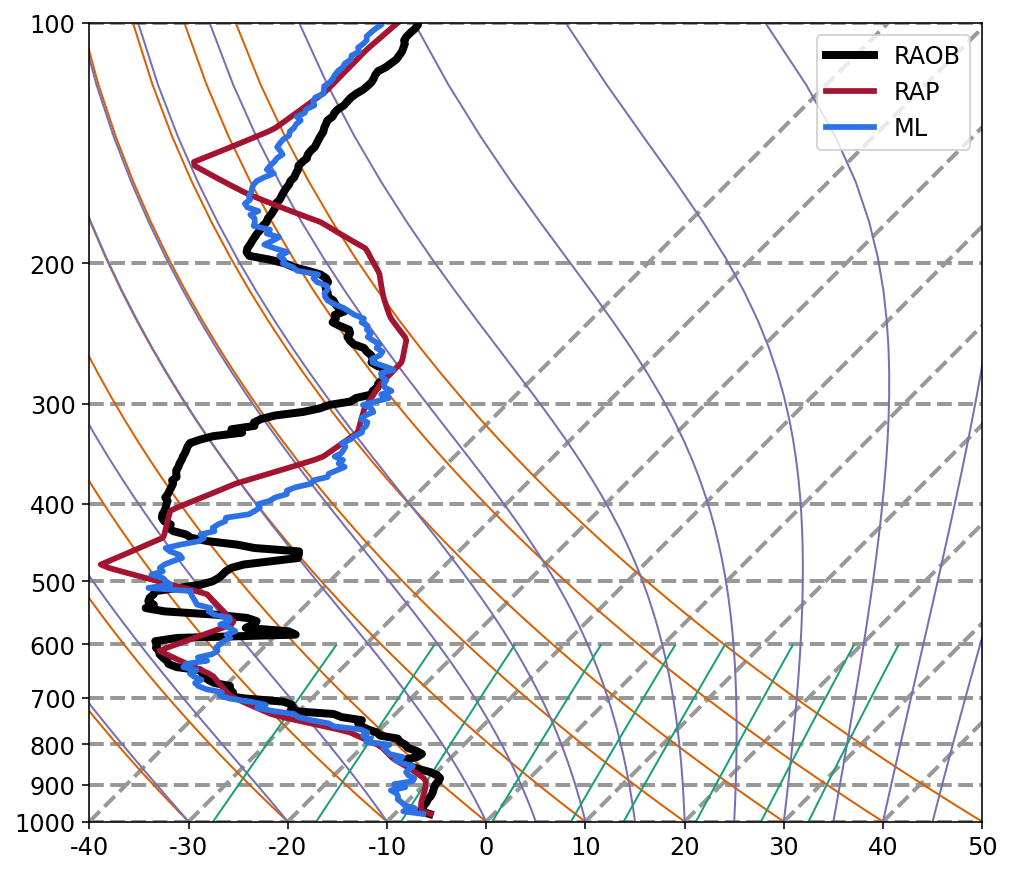

In [53]:
i = 4
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## UNet Model

### Temperature

In [5]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=True)

input_dims = [dl.TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((14038, 256, 1), (14038, 256), (3510, 256, 1), (3510, 256))

In [6]:
nnet = nn.SkipNeuralNetwork(Xtrain.shape[1:], [8, 8], [(10, 1)]*2,
                         Ttrain.shape[1], activation='tanh',
                         n_hidden_dims=32, seed=1234)
nnet.model.summary()
# nnet.train(Xtrain, Ttrain, 35, 32, method='adam', verbose=False,
#            learning_rate=0.001, validation=[Xtest, Ttest])

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 8)       88          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 8)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 128, 8)       0           activation[0][0]                 
_______________________________________________________________________________________

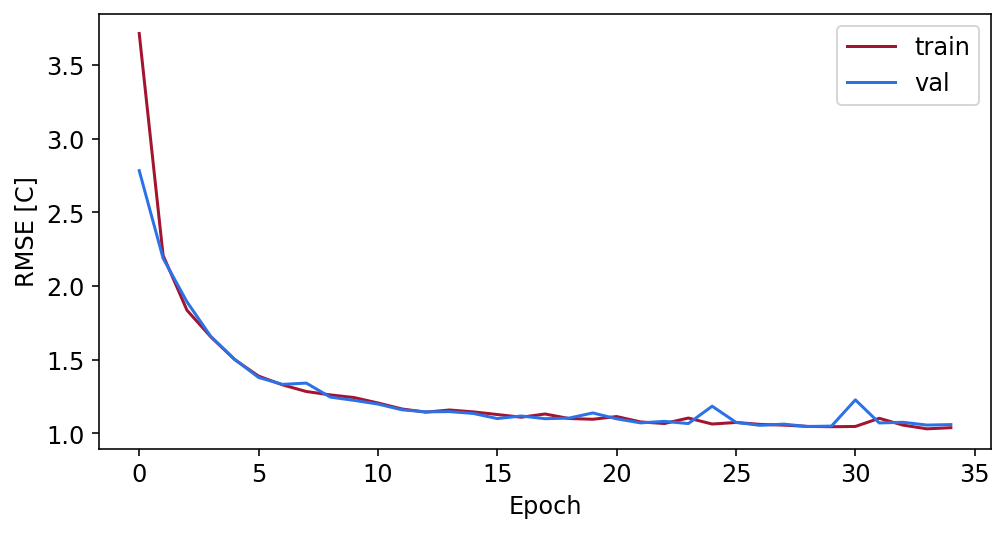

In [33]:
results.plot_loss(nnet)

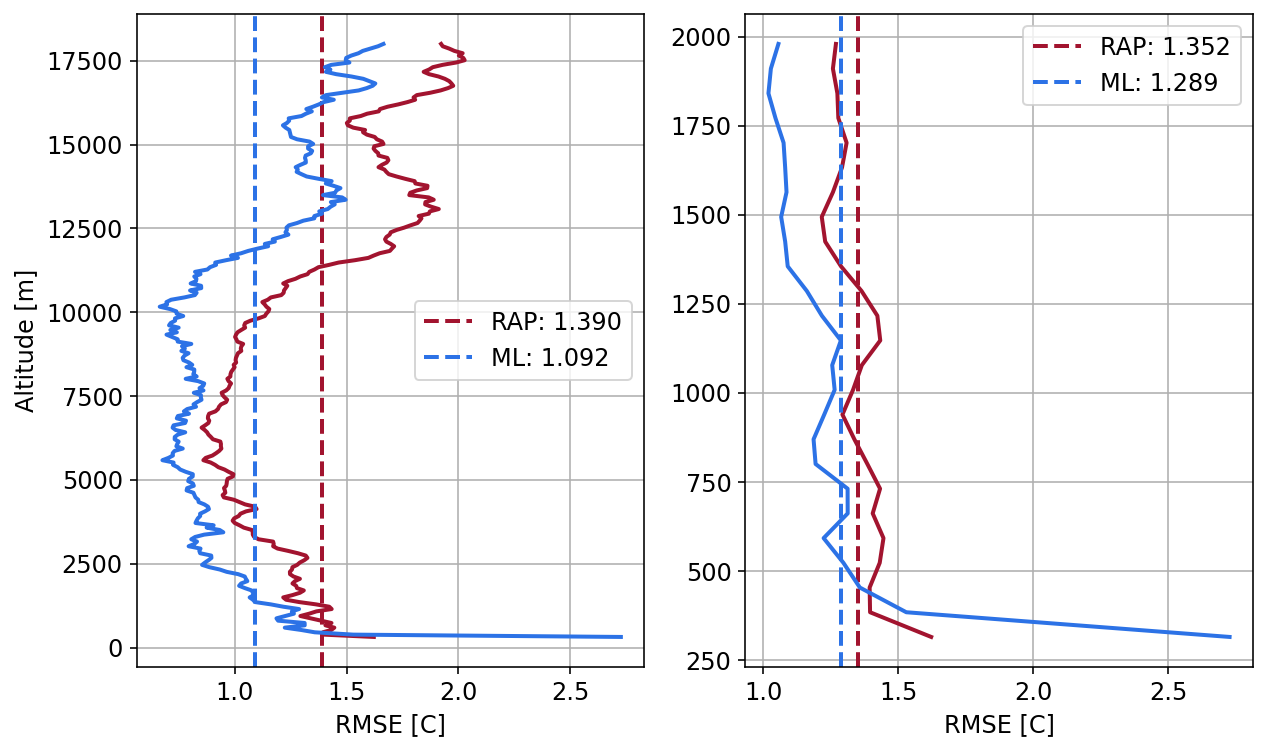

In [34]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,dl.TEMPERATURE], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

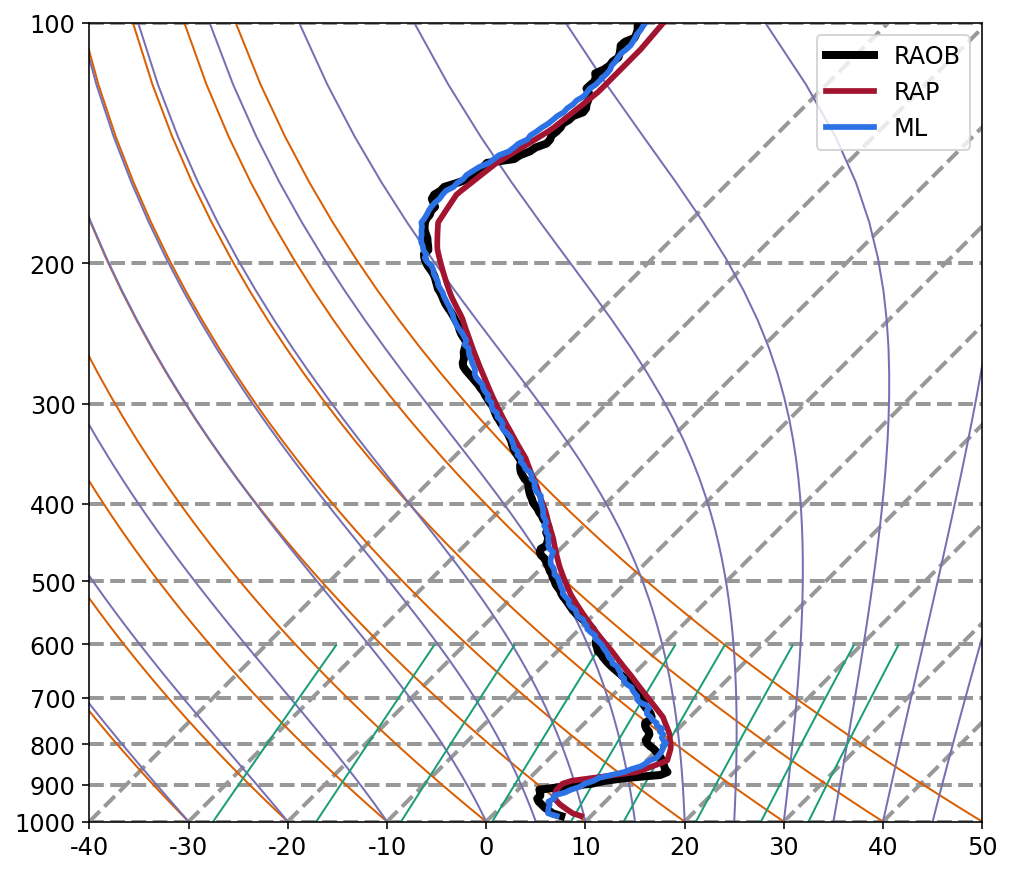

In [35]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

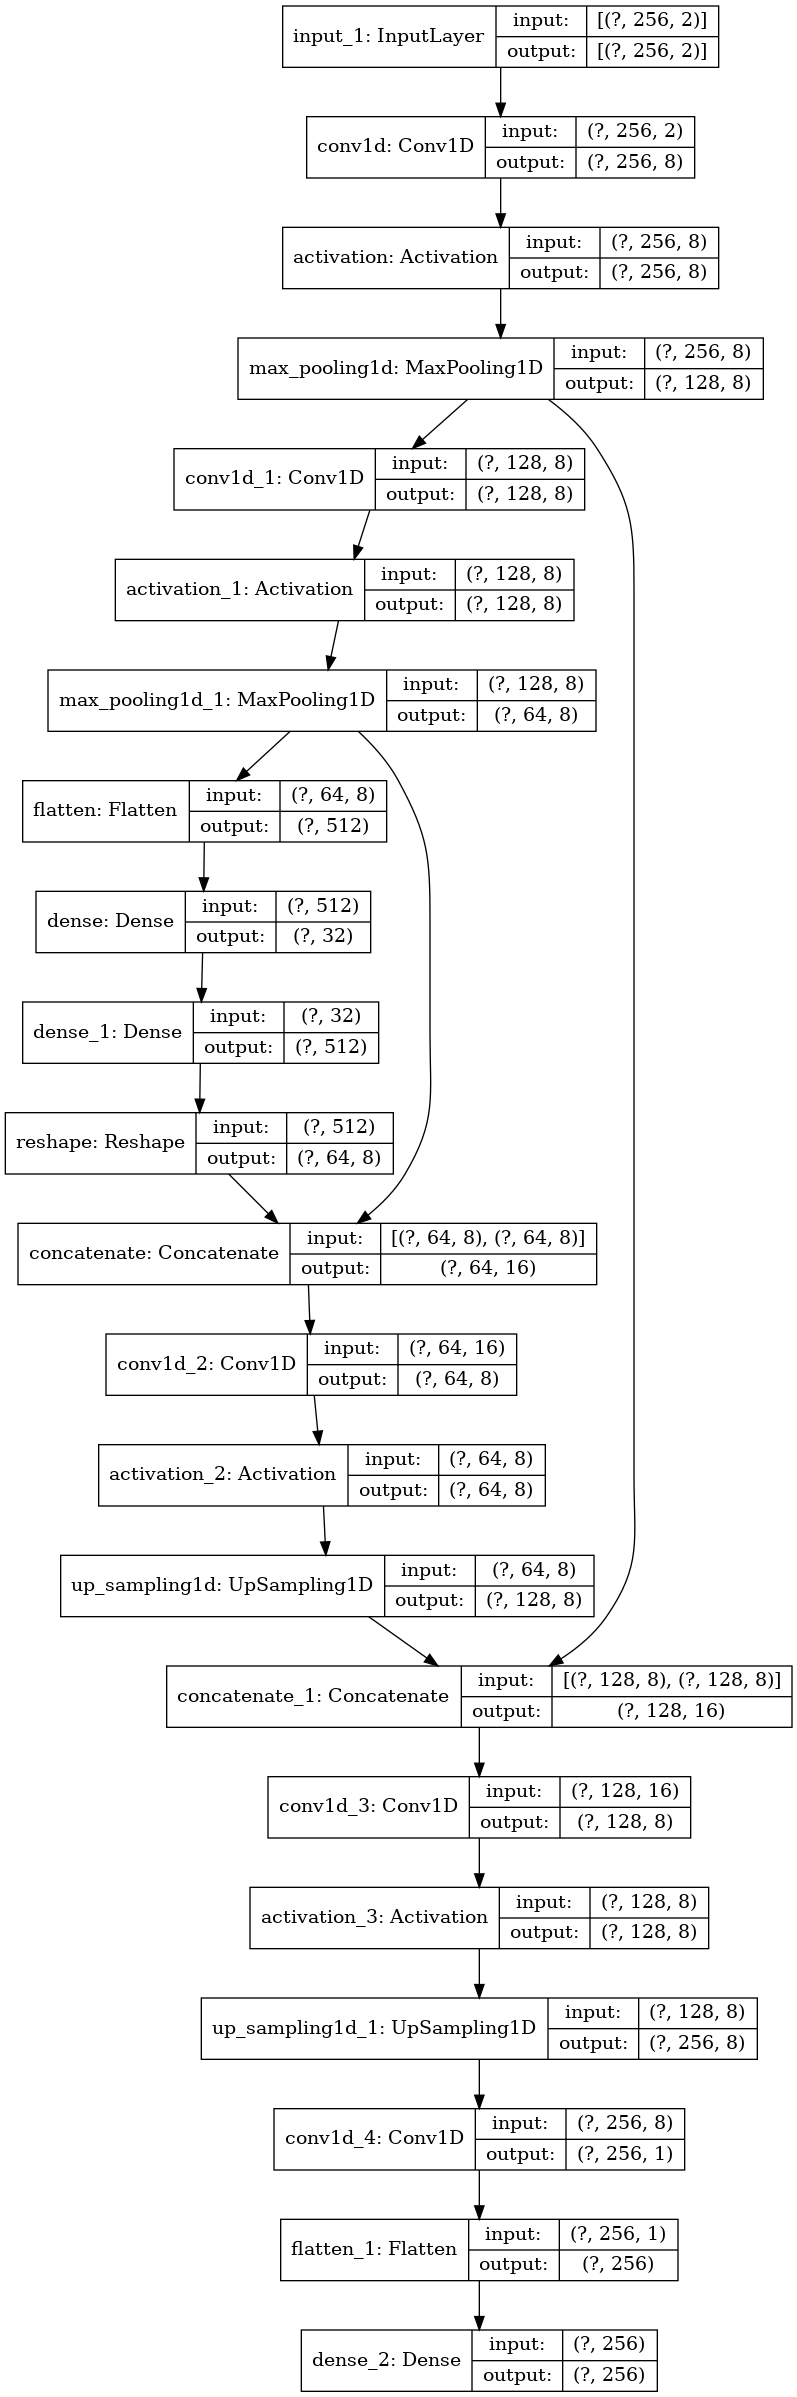

In [36]:
tf.keras.utils.plot_model(nnet.model, '/home/stock/research/media/unet.png',
                          show_shapes=True, rankdir='TB', dpi=96) # LR/TB positioning

### Moisture

In [60]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.DEWPOINT]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.DEWPOINT]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.DEWPOINT]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 2), (1026, 256), (257, 256, 2), (257, 256))

In [61]:
nnet = nn.SkipNeuralNetwork(Xtrain.shape[1:], [8, 8], [(10, 1)]*2,
                         Ttrain.shape[1], activation='tanh',
                         n_hidden_dims=32, seed=1234)
nnet.train(Xtrain, Ttrain, 35, 32, method='adam', verbose=False,
           learning_rate=0.001, validation=[Xtest, Ttest])

SkipNeuralNetwork((256, 2), [8, 8], [(10, 1), (10, 1)], 256)
  Final objective value is 0.23159 in 9.6398 seconds.

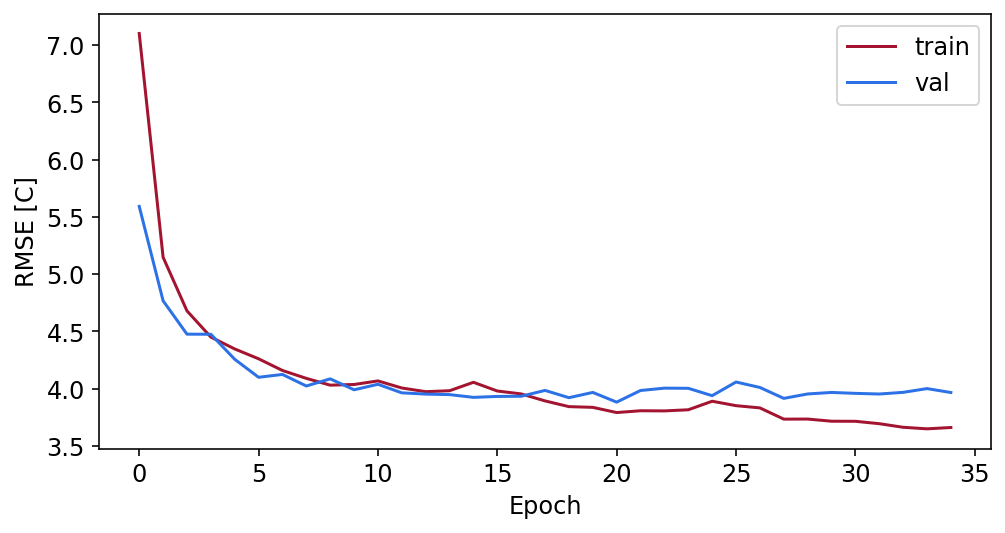

In [62]:
results.plot_loss(nnet)

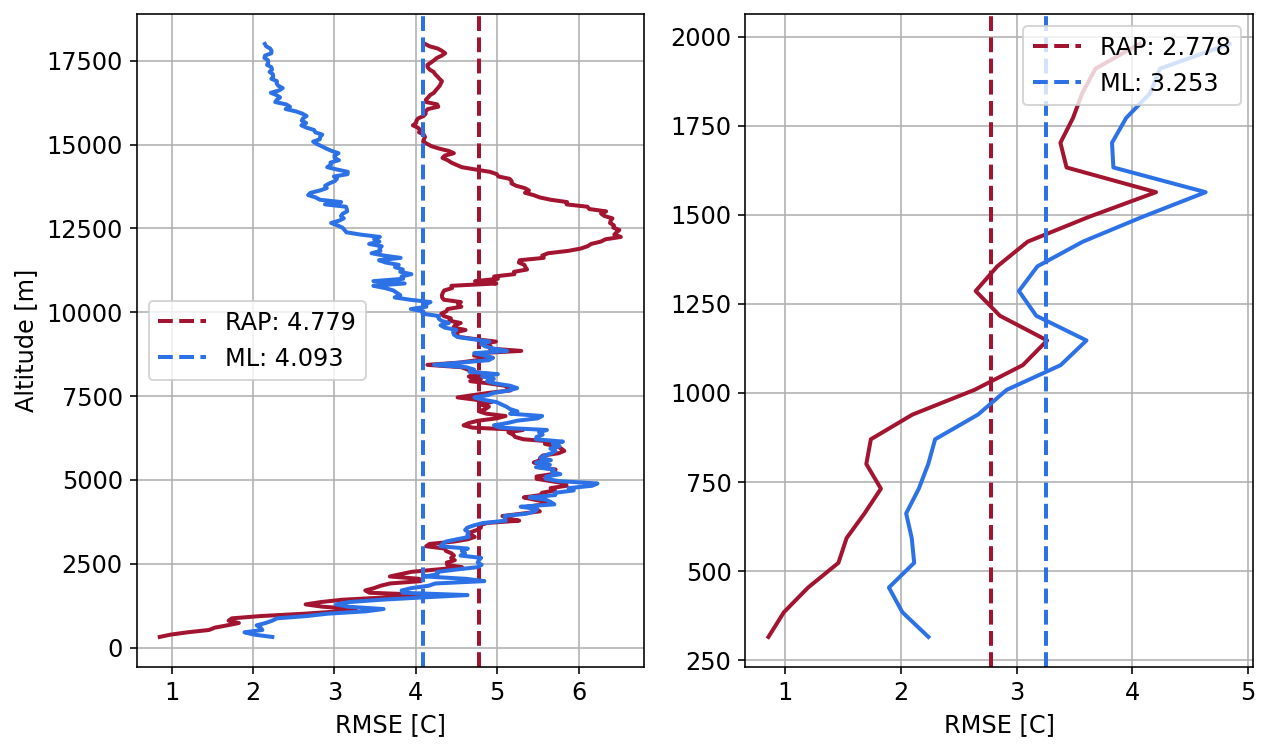

In [63]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/raob_cae_rmse.png")

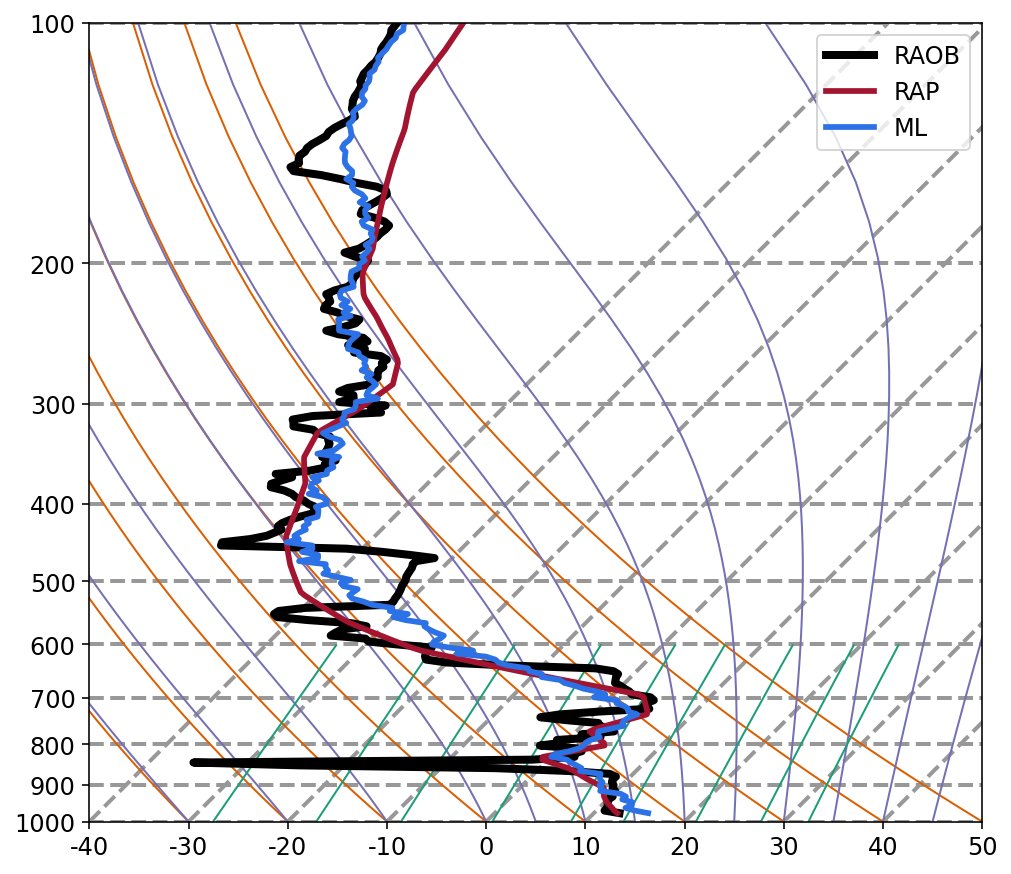

In [64]:
i = 15
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1,:])[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

## Transfer Learning RAOB

Best performance is noticed when retraining over the entire model, or freezing the weights before the latent vector.

In [37]:
def insert_intermediate_layer(model, layer_regex, layer_factory):
    x = model.layers[0].output
    for layer in model.layers[1:]:
        x = layer(x)
        if re.match(layer_regex, layer.name):
            new_layer = layer_factory()
            new_layer._name = f'{layer.name}_{new_layer.name}'
            x = new_layer(x)
            print(f'Added {new_layer.name} after {layer.name}')
    return tf.keras.Model(model.layers[0].input, x)

In [39]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(rap, raob, (0.8,0.2), shuffle=False)

input_dims = [dl.PRESSURE, dl.TEMPERATURE]

Xtrain = Xtrain[:, :, input_dims]
Ttrain = Ttrain[:, :, dl.TEMPERATURE]

Xtest = Xtest[:, :, input_dims]
Ttest = Ttest[:, :, dl.TEMPERATURE]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1026, 256, 2), (1026, 256), (257, 256, 2), (257, 256))

In [59]:
## 0.970 with raob_cae freeze before `dense` with 20, 32, 0.0001 'adam'

nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_cae')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_moisture_cae')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_noisy_cae')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_temperature_cnn')
# nnet = nn.loadnn('/mnt/data1/stock/mlsoundings/models/raob_noisy_temperature_cae')

def dropout_layer_factory():
    return tf.keras.layers.Dropout(rate=0.2, name='dropout')
def batchnorm_layer_factory():
    return tf.keras.layers.BatchNormalization(name='batch_norm')

# (?<![\w\d])dense(?![\w\d])
# nnet.model = insert_intermediate_layer(nnet.model, '(?<![\w\d])conv1d(?![\w\d])', batchnorm_layer_factory)
# nnet.model = insert_intermediate_layer(nnet.model, 'max_pool', dropout_layer_factory)

# for layer in nnet.model.layers[:-2]:
#     if layer == nnet.model.get_layer('dense'):
#         break
#     layer.trainable = False
    
nnet.model.trainable = False
    
# Remove last Dense layer and add new one.
x = nnet.model.layers[-2].output
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256)(x)
nnet.model = tf.keras.Model(nnet.model.layers[0].input, x)
    
nnet.train(Xtrain, Ttrain, 20, 32, validation=[Xtest, Ttest], method='adam',
                 learning_rate=0.001, verbose=True)

epoch: 0, rmse 4.95107, val_rmse 3.85870
epoch: 5, rmse 2.17407, val_rmse 1.64850
epoch: 10, rmse 1.85505, val_rmse 1.29578
epoch: 15, rmse 1.72353, val_rmse 1.18399
epoch: 19, rmse 1.66528, val_rmse 1.14644
finished!


ConvolutionalAutoEncoder((256, 2), [8, 8], [(10, 1), (10, 1)], 256)
  Final objective value is 0.08971 in 4.2490 seconds.

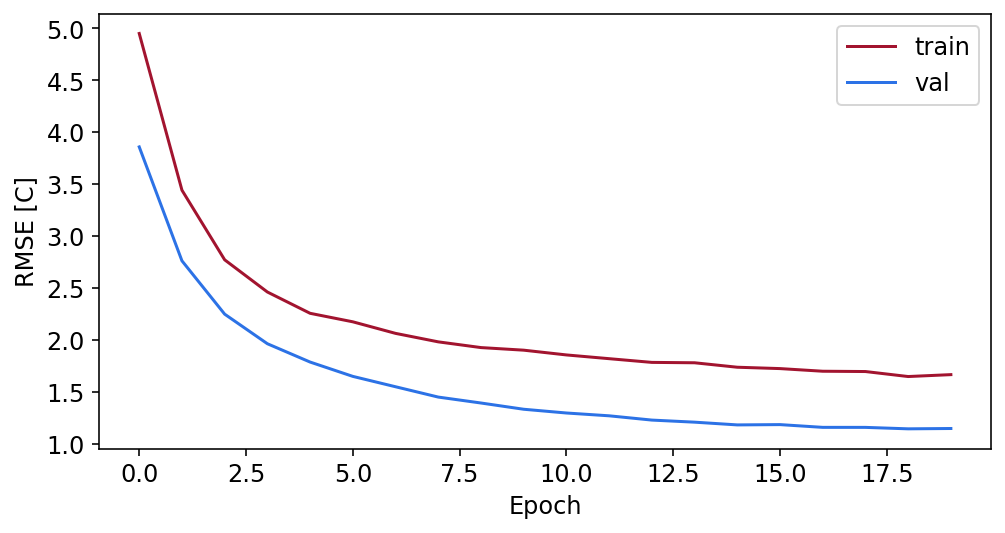

In [61]:
results.plot_loss(nnet)

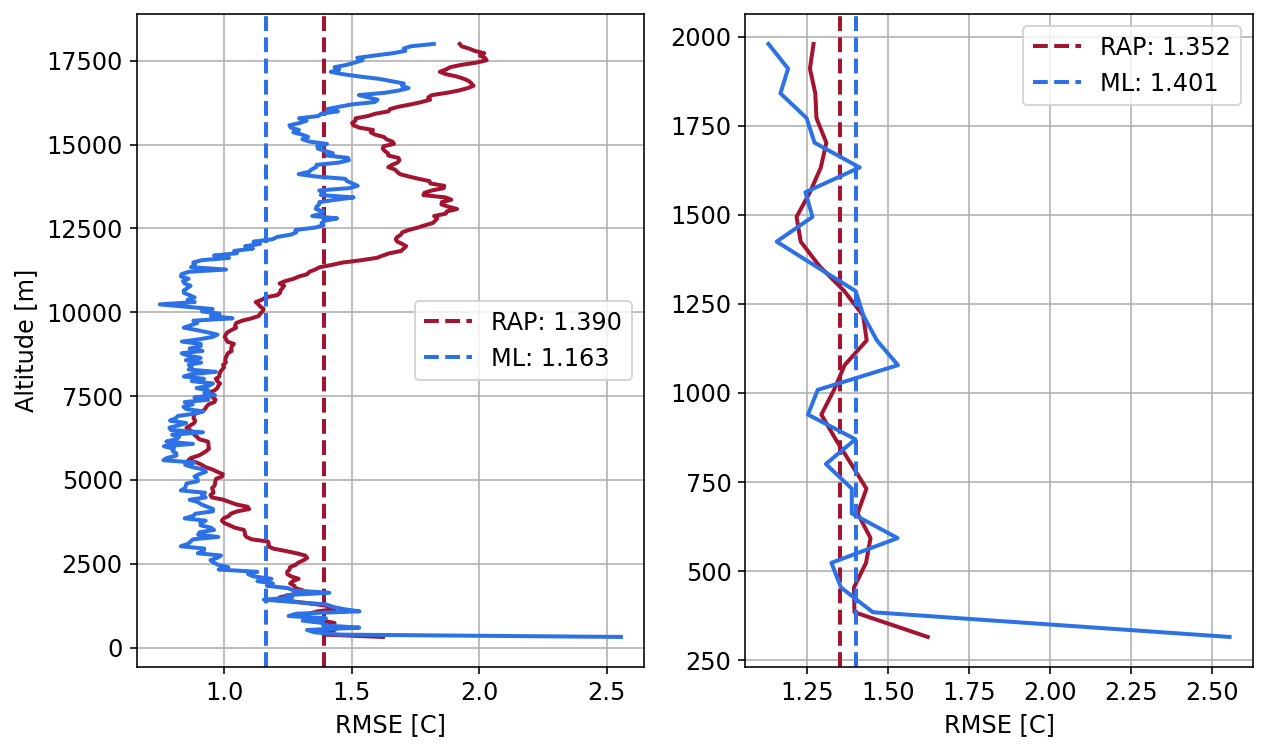

In [62]:
results.plot_altitude_rmse_verticle(nnet, Xtest, Ttest, Xtest[:,:,-1], alt=raob[0, :, -1])
                            # file_name=f"/home/stock/research/media/transferlearning-temp-profile.png")

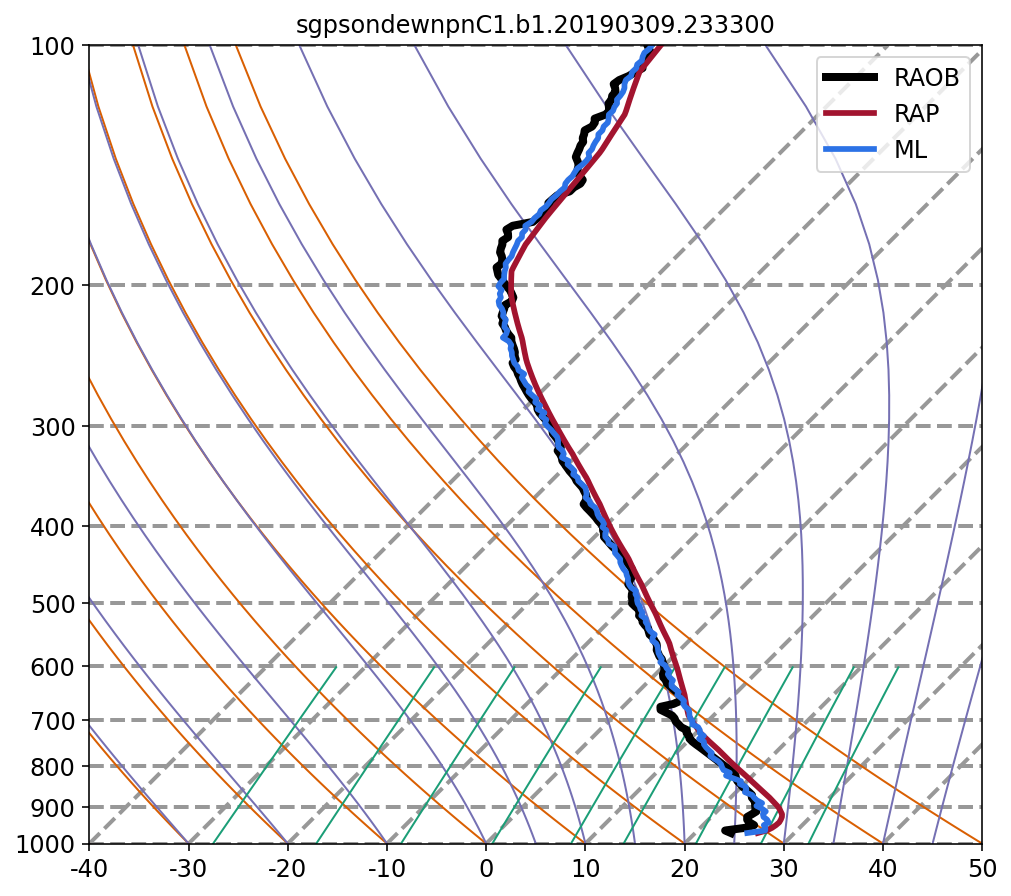

In [60]:
i = 69 # 69
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = Xtest[i,:,dl.PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = Ttest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = Xtest[i,:,dl.TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use(Xtest[i:i+1])[0]

# sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = Ttest[i,:,1]
# sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = Xtest[i,:,dl.DEWPOINT]
# sounding[radiosonde_utils.PREDICTED_DEWPOINT_COLUMN_KEY] = moist_nnet.use(Xtest[i:i+1,:,[dl.PRESSURE,dl.DEWPOINT]])[0]

title = sonde_files[i].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");